# Предсказание температуры сплава (металлургия)

## Описание проекта

### Цель

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать.

Метрика оценки модели МАЕ на тестовой выборке не должна превышать 6.8. Заказчик просит дополнительно рассчитать метрику R2 для лучшей модели на тестовой выборке и интерпретировать ее.\
У лучшей модели необходимо исследовать важность признаков  и написать отдельный вывод по важности.\
Установлена конcтанта random_state  = 200524.\
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.\
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).\
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:\
`data_arc_new.csv` — данные об электродах;\
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);\
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);\
`data_gas_new.csv` — данные о продувке сплава газом;\
`data_temp_new.csv` — результаты измерения температуры;\
`data_wire_new.csv` — данные о проволочных материалах (объём);\
`data_wire_time_new.csv` — данные о проволочных материалах (время).

1. **data_arc_new.csv**\
`key` — номер партии;\
`Начало нагрева дугой` — время начала нагрева;\
`Конец нагрева дугой` — время окончания нагрева;\
`Активная мощность` — значение активной мощности;\
`Реактивная мощность` — значение реактивной мощности.

2. **data_bulk_new.csv**\
`key` — номер партии;\
`Bulk 1` … `Bulk 15` — объём подаваемого материала.

3. **data_bulk_time_new.csv**\
`key` — номер партии;\
`Bulk 1` … `Bulk 15` — время подачи материала.

4. **data_gas_new.csv**\
`key` — номер партии;\
`Газ 1` — объём подаваемого газа.

5. **data_temp_new.csv**\
`key` — номер партии;\
`Время замера` — время замера;\
`Температура` — значение температуры.

6. **data_wire_new.csv**\
`key` — номер партии;\
`Wire 1` … `Wire 15` — объём подаваемых проволочных материалов.

7. **data_wire_time_new.csv**\
`key` — номер партии;\
`Wire 1` … `Wire 15` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Загрузка библиотек и датасетов

### Загрузка библиотек, классов и метрик

In [1]:
!pip install --upgrade scikit-learn=='1.4.0' -q
!pip install phik -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (18,8)

import time

import sklearn
import phik

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller
# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error, r2_score

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, recall_score, precision_score, accuracy_score,
    roc_auc_score, make_scorer
)

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
sklearn.__version__

'1.4.0'

In [4]:
# константа

RANDOM_STATE = 200524

### Загрузка данных и знакомство с ними

In [5]:
import os

pth1 = '/datasets/data_arc_new.csv'
pth2 = '/content/data_arc_new.csv'

if os.path.exists(pth1):
    data_arc_new = pd.read_csv(pth1, sep=',')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv', sep=',')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv', sep=',')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv', sep=',')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', sep=',')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv', sep=',')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv', sep=',')
elif os.path.exists(pth2):
    data_arc_new = pd.read_csv(pth2, sep=',')
    data_bulk_new = pd.read_csv('/content/data_bulk_new.csv', sep=',')
    data_bulk_time_new = pd.read_csv('/content/data_bulk_time_new.csv', sep=',')
    data_gas_new = pd.read_csv('/content/data_gas_new.csv', sep=',')
    data_temp_new = pd.read_csv('/content/data_temp_new.csv', sep=',')
    data_wire_new = pd.read_csv('/content/data_wire_new.csv', sep=',')
    data_wire_time_new = pd.read_csv('/content/data_wire_time_new.csv', sep=',')
else:
    print('Patherror')

In [6]:
# Посмотрим на датасеты
datasets = {'data_arc_new' : data_arc_new,
            'data_bulk_new': data_bulk_new,
            'data_bulk_time_new' : data_bulk_time_new,
            'data_gas_new' : data_gas_new,
            'data_temp_new' : data_temp_new,
            'data_wire_new' : data_wire_new,
            'data_wire_time_new' : data_wire_time_new
           }

for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.head(5))
    display(dataset.info())
    print('Партий:',len(dataset['key'].unique()))
    print('Явных дубликатов:', dataset.duplicated().sum())
    print()

data_arc_new
_____________________________________


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Партий: 3214
Явных дубликатов: 0

data_bulk_new
_____________________________________


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Партий: 3129
Явных дубликатов: 0

data_bulk_time_new
_____________________________________


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Партий: 3129
Явных дубликатов: 0

data_gas_new
_____________________________________


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Партий: 3239
Явных дубликатов: 0

data_temp_new
_____________________________________


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Партий: 3216
Явных дубликатов: 0

data_wire_new
_____________________________________


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Партий: 3081
Явных дубликатов: 0

data_wire_time_new
_____________________________________


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Партий: 3081
Явных дубликатов: 0



**Знакомство с данными**\
`data_arc_new.csv` — данные об электродах:\
В датасете 5 колонок: ключ (номер партии), Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность\
Всего строк: 14876, нулей нет. Явных дубликатов нет. Уникальных ключей (партий) 3214. Одному ключу может соотвествовать несколько строк, это нормально, поскольку нагрев производится несколько раз в течение процесса.\
Нам будут нужны лишь начальная и конечная температуры. Данные промежуточных температур, а также ключи с единственной итерацией необходимо будет удалить.\
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):\
В датасете 16 колонок: ключ (номер партии) и 15 колонок сыпучих примесей, обозначенные Bulk1 - Bulk15. Всего 3129 строк, Уникальных ключей (партий) 3129. В колонке ключ нулевых значений нет (и они все уникальные), в колонках примесей есть пропуски, но это нормально, поскольку не все примеси добавляются в каждую партию. Следует заменить значением 0. Явных дубликатов нет.\
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):\
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом\
Уникальных ключей (партий) 3129 равно числу строк. В колонке ключ нулевых значений нет (и они все уникальные). Явных дубликатов нет.\
`data_gas_new.csv` — данные о продувке сплава газом:\
2 колонки, ключ и Газ1, видимо, объем газа. Строк 3239, что на 110 строк больше, чем в датафреймах с сыпучими добавками. Пропусков нет. Уникальных ключей (партий) 3239 равно числу строк. Явных дубликатов нет. \
`data_temp_new.csv` — результаты измерения температуры:\
3 колонки: ключ, время замера и температура. 18092 строк, есть пропуски в колонке "температура", при этом в колонке "время замера" пропусков нет. Явных дубликатов нет. Уникальных ключей (партий) 3216. Одному ключу может соотвествовать несколько строк, это нормально, поскольку замер температуры производится несколько раз в течение процесса.\
`data_wire_new.csv` — данные о проволочных материалах (объём):\
10 колонок: ключ и колонки Wire 1 - Wire 9, отвечающие за проволочные присадки. 3081 строка, в колонках проволочных присадок есть пропуски, их можно заменить нулями. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет.
`data_wire_time_new.csv` — данные о проволочных материалах (время):
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет..\

Кроме описанной предобработки также следует привести названия колонок к snake_case. Можно посмотреть количество уникальных значений в колонке `key` по всем датасетам

In [7]:
for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.describe())

data_arc_new
_____________________________________


key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

data_bulk_new
_____________________________________


key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

data_bulk_time_new
_____________________________________


key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

data_gas_new
_____________________________________


key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

data_temp_new
_____________________________________


key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

data_wire_new
_____________________________________


key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

data_wire_time_new
_____________________________________


key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

`data_arc_new.csv` — данные об электродах:\
Есть отрицательное значение реактивной мощности - это выброс.\
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):\
Можно отметить одну примесь, которая была использована лишь раз. Полагаю, лучше ее оставить, она может быть важна для процесса.\
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):\
здесь статистики смотреть бессмысленно: они только на колонку key\
`data_gas_new.csv` — данные о продувке сплава газом:\
Странно выглядит минимум, лучше уточнить на боксплоте\
`data_temp_new.csv` — результаты измерения температуры:\
Минимум температуры меньше 1500С, все эти значения потребуется убрать, они ниже точки плавления стали\
`data_wire_new.csv` — данные о проволочных материалах (объём):\
Можно отметить одну примесь, которая была использована лишь раз. Полагаю, лучше ее оставить, она может быть важна для процесса.\
`data_wire_time_new.csv` — данные о проволочных материалах (время):
здесь статистики смотреть бессмысленно: они только на колонку key


### Промежуточный вывод после знакомства с данными

`data_arc_new.csv` — данные об электродах:\
В датасете 5 колонок: ключ (номер партии), Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность\
Всего строк: 14876, нулей нет. Явных дубликатов нет. Уникальных ключей (партий) 3214. Одному ключу может соотвествовать несколько строк, это нормально, поскольку нагрев производится несколько раз в течение процесса.\
Нам будут нужны лишь начальная и конечная температуры. Данные промежуточных температур, а также ключи с единственной итерацией необходимо будет удалить.\
Есть отрицательное значение реактивной мощности - это выброс.\
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):\
В датасете 16 колонок: ключ (номер партии) и 15 колонок сыпучих примесей, обозначенные Bulk1 - Bulk15. Всего 3129 строк, Уникальных ключей (партий) 3129. В колонке ключ нулевых значений нет (и они все уникальные), в колонках примесей есть пропуски, но это нормально, поскольку не все примеси добавляются в каждую партию. Следует заменить значением 0. Явных дубликатов нет.\
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):\
Одна примесь из всех была использована лишь раз. Полагаю, лучше ее оставить, она может быть важна для процесса.\
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом\
Уникальных ключей (партий) 3129 равно числу строк. В колонке ключ нулевых значений нет (и они все уникальные). Явных дубликатов нет.\
`data_gas_new.csv` — данные о продувке сплава газом:\
2 колонки, ключ и Газ1, видимо, объем газа. Строк 3239, что на 110 строк больше, чем в датафреймах с сыпучими добавками. Пропусков нет. Уникальных ключей (партий) 3239 равно числу строк. Явных дубликатов нет. \
Странно выглядит минимум, лучше уточнить на боксплоте.\
`data_temp_new.csv` — результаты измерения температуры:\
3 колонки: ключ, время замера и температура. 18092 строк, есть пропуски в колонке "температура", при этом в колонке "время замера" пропусков нет. Ключи с пропуском в замерах требуется удалить. Явных дубликатов нет. Уникальных ключей (партий) 3216. Одному ключу может соотвествовать несколько строк, это нормально, поскольку замер температуры производится несколько раз в течение процесса.\
Минимум температуры меньше 1500С, все эти значения потребуется убрать, они ниже точки плавления стали\
`data_wire_new.csv` — данные о проволочных материалах (объём):\
10 колонок: ключ и колонки Wire 1 - Wire 9, отвечающие за проволочные присадки. 3081 строка, в колонках проволочных присадок есть пропуски, их можно заменить нулями. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет. \
Одна примесь из всех была использована лишь раз. Полагаю, лучше ее оставить, она может быть важна для процесса.\
`data_wire_time_new.csv` — данные о проволочных материалах (время):
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет.\

Кроме описанной предобработки также следует привести названия колонок к snake_case. Можно посмотреть количество уникальных значений в колонке `key` по всем датасетам


## Исследовательский анализ и предобработка данных

### Изменение типов данных и приведение названий столбцов к snake_case

In [8]:
# перезапишем датасеты с учетом изменения типов данных:

if os.path.exists(pth1):
    arc = pd.read_csv(pth1, sep=',', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    bulk = pd.read_csv('/datasets/data_bulk_new.csv', sep=',')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', sep=',', parse_dates=['Bulk 1',  'Bulk 2',
                                                                                               'Bulk 3',  'Bulk 4',  'Bulk 5',
                                                               'Bulk 6',  'Bulk 7',  'Bulk 8',  'Bulk 9',  'Bulk 10',
                                                               'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    gas = pd.read_csv('/datasets/data_gas_new.csv', sep=',')
    temp = pd.read_csv('/datasets/data_temp_new.csv', sep=',', parse_dates=['Время замера'], dtype={'Температура':'Int64'})
    wire = pd.read_csv('/datasets/data_wire_new.csv', sep=',')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', sep=',', parse_dates=['Wire 1', 'Wire 2', 'Wire 3',
                                                                                               'Wire 4', 'Wire 5',
                                                               'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
elif os.path.exists(pth2):
    arc = pd.read_csv(pth2, sep=',', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    bulk = pd.read_csv('/content/data_bulk_new.csv', sep=',')
    bulk_time = pd.read_csv('/content/data_bulk_time_new.csv', sep=',', parse_dates=['Bulk 1',  'Bulk 2',  'Bulk 3',
                                                                                              'Bulk 4',  'Bulk 5',
                                                               'Bulk 6',  'Bulk 7',  'Bulk 8',  'Bulk 9',  'Bulk 10',
                                                               'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    gas = pd.read_csv('/content/data_gas_new.csv', sep=',')
    temp = pd.read_csv('/content/data_temp_new.csv', sep=',', parse_dates=['Время замера'], dtype={'Температура':'Int64'})
    wire = pd.read_csv('/content/data_wire_new.csv', sep=',')
    wire_time = pd.read_csv('/content/data_wire_time_new.csv', sep=',', parse_dates=['Wire 1', 'Wire 2', 'Wire 3',
                                                                                               'Wire 4', 'Wire 5',
                                                               'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
else:
    print('Patherror')

In [9]:
#контроль
datasets = {'data_arc_new' : arc,
            'data_bulk_new': bulk,
            'data_bulk_time_new' : bulk_time,
            'data_gas_new' : gas,
            'data_temp_new' : temp,
            'data_wire_new' : wire,
            'data_wire_time_new' : wire_time
           }

for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.info())

data_arc_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

data_bulk_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

data_bulk_time_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)

None

data_gas_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

data_temp_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), int64(1)
memory usage: 441.8 KB


None

data_wire_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

data_wire_time_new
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

In [10]:
#Переименуем колонки
arc.columns       = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']
bulk.columns      = ['key',    'bulk_1', 'bulk_2',  'bulk_3',  'bulk_4',  'bulk_5',  'bulk_6',  'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
bulk_time.columns = ['key',    'bulk_1', 'bulk_2',  'bulk_3',  'bulk_4',  'bulk_5',  'bulk_6',  'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
gas.columns       = ['key', 'gas']
temp.columns      = ['key', 'time', 'temp']
wire.columns      = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [11]:
#контроль
for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.columns)

data_arc_new
_____________________________________


Index(['key', 'heating_start', 'heating_end', 'active_power',
       'reactive_power'],
      dtype='object')

data_bulk_new
_____________________________________


Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

data_bulk_time_new
_____________________________________


Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

data_gas_new
_____________________________________


Index(['key', 'gas'], dtype='object')

data_temp_new
_____________________________________


Index(['key', 'time', 'temp'], dtype='object')

data_wire_new
_____________________________________


Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

data_wire_time_new
_____________________________________


Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### data_arc_new: обработка данных и исследовательский анализ датасета

В данном датафрейме собраны данные по мощности - активной и реактивной.

Активная мощность — это электрическая энергия, которая идёт на выполнение полезной работы (обогрев, освещение и пр.). Её принято измерять в ваттах и киловаттах (Вт, кВт).

Реактивная мощность — это электрическая энергия, которая накапливается в электрических цепях, но не участвует в выполнении полезной работы. Она идёт на разогрев проводников и возвращается в электрическую сеть.

Полная мощность равна корню квадратному суммы квадратов активной и реактивной мщностей.

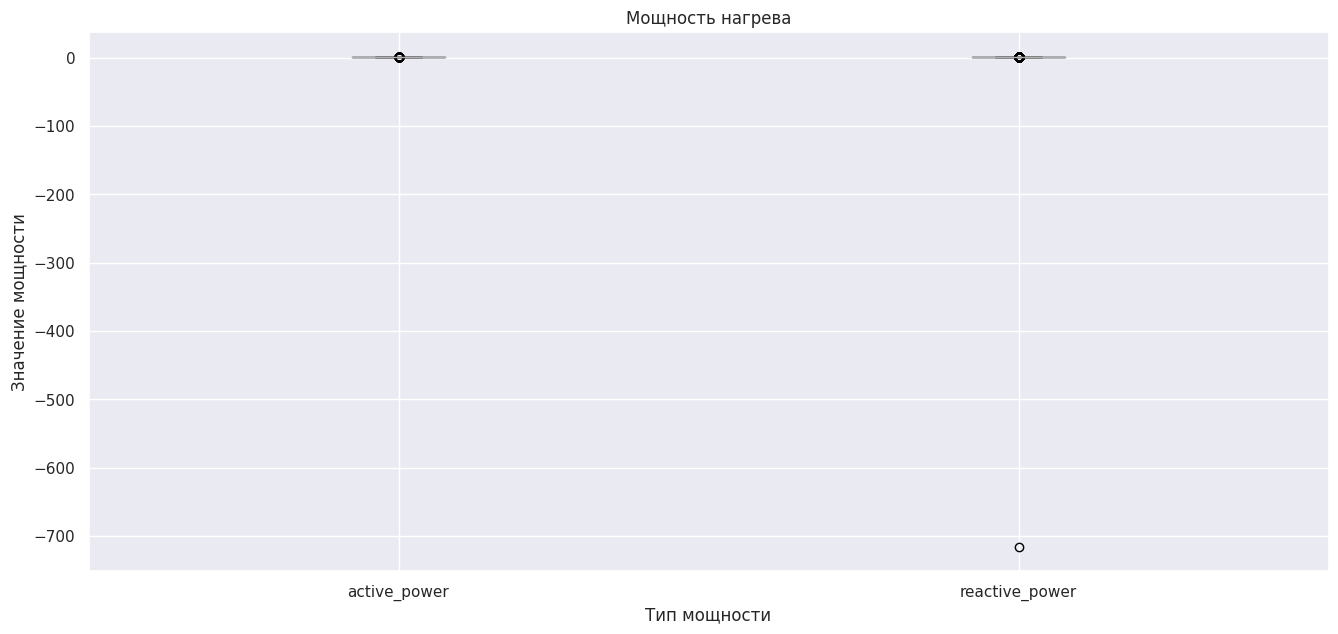

key                  heating_start  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                         heating_end  active_power  reactive_power  
count                          14876  14876.000000    14876.000000  
mean   2019-07-05 12:28:43.592027392      0.662752        0.438986  
min              2019-05-03 11:06:02      0.223120     -715.479924  
25%              2019-06-03 23:21:35      0.467115        0.337175  
50%              2019-07-03 01:35:13      0.599587        0.441639  
75%              2019-08-07 22:56:47      0.830070        0.608201  
max              2019-09-06 17:26:15      1.463773        1.270284  
std                              NaN      0.258885        5.873485

In [12]:
arc.loc[:, 'active_power':'reactive_power'].boxplot(figsize=(16, 7))
plt.title('Мощность нагрева')
plt.ylabel('Значение мощности')
plt.xlabel('Тип мощности')
plt.show()

arc.describe()

Наблюдается аномалия в области отрицательных значений в столбце реактивной мощности со значением -715.479924. Этот ключ нужно удалить, поскольку не представляется возможным угадать. какое именно значение там было.

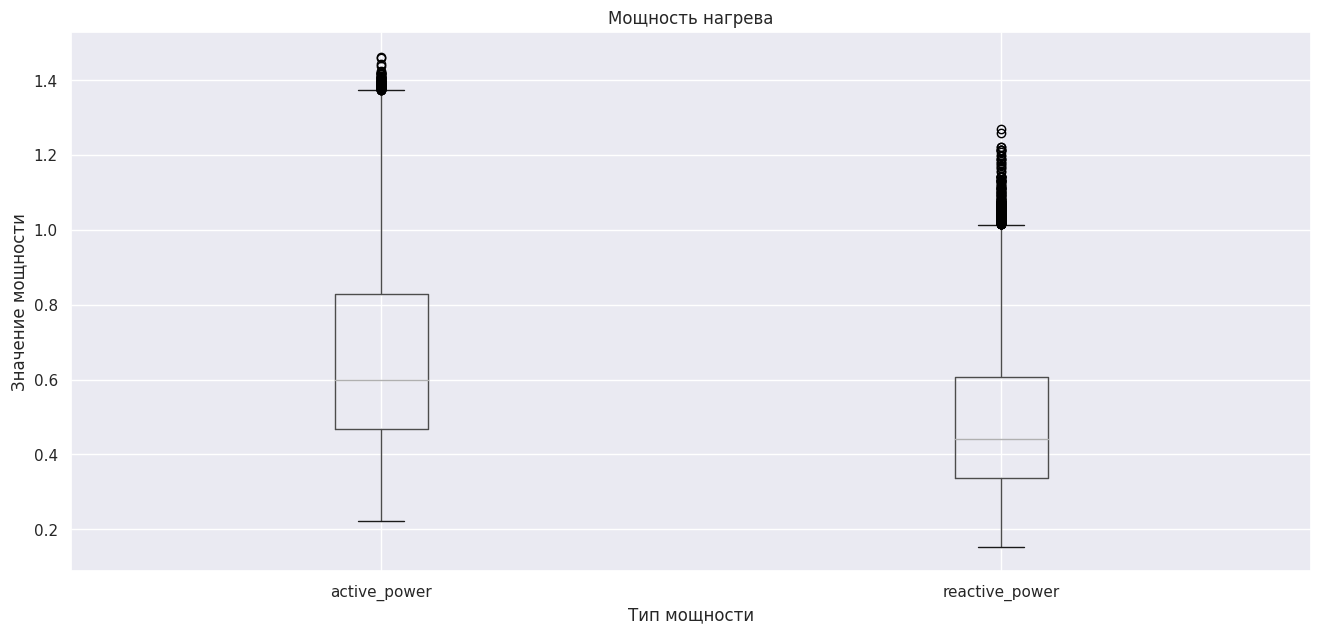

key                  heating_start  \
count  14875.000000                          14875   
mean    1615.186756  2019-07-05 12:23:40.763025152   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000     2019-06-03 23:13:02.500000   
50%     1617.000000            2019-07-03 01:28:12   
75%     2429.000000     2019-08-07 22:54:16.500000   
max     3241.000000            2019-09-06 17:24:54   
std      934.593897                            NaN   

                         heating_end  active_power  reactive_power  
count                          14875  14875.000000    14875.000000  
mean   2019-07-05 12:26:32.438184960      0.662749        0.487115  
min              2019-05-03 11:06:02      0.223120        0.153777  
25%              2019-06-03 23:16:13      0.467115        0.337190  
50%              2019-07-03 01:31:27      0.599578        0.441665  
75%              2019-08-07 22:57:54      0.830135        0.608223  
max              2019-09-06 17:26:15      1.463773        1.270284  
std                              NaN      0.258894        0.197612

In [13]:
arc = arc.loc[arc['reactive_power'] != -715.479924]

# Контроль
arc.loc[:, 'active_power':'reactive_power'].boxplot(figsize=(16, 7))
plt.title('Мощность нагрева')
plt.ylabel('Значение мощности')
plt.xlabel('Тип мощности')
plt.show()

arc.describe()

In [14]:
# контроль неэффективной работы
print('Активная мощность меньше реактивной:')
display(arc[arc['active_power'] < arc['reactive_power']])

Активная мощность меньше реактивной:


Empty DataFrame
Columns: [key, heating_start, heating_end, active_power, reactive_power]
Index: []

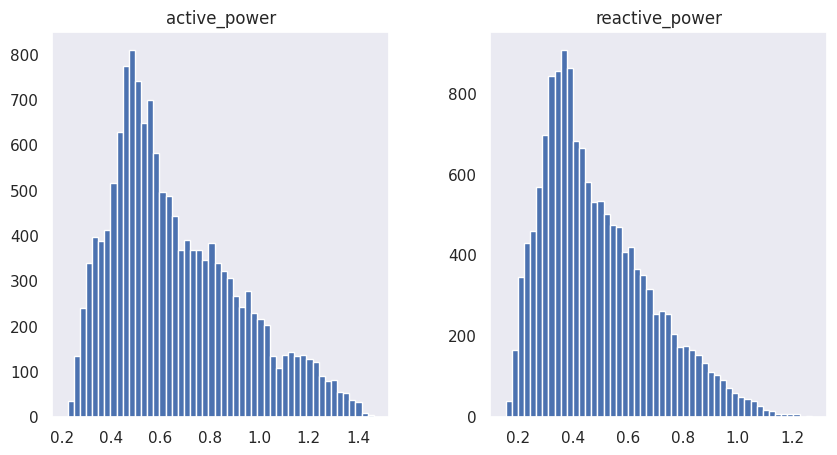

In [15]:
# распределения данных о электродах
arc[['active_power','reactive_power']].hist(figsize=(10,5), grid=False, bins=50)
plt.show()

Рассчитаем полную мощность и время нагрева дугой. Посмотрим аномалии в новых столбцах.

In [16]:
arc['full_power'] = (arc['active_power']**2 + arc['reactive_power']**2)**(0.5)
arc['heating_time'] = (arc['heating_end'] - arc['heating_start']).astype('timedelta64[s]')
arc['heating_time'] = arc['heating_time'].astype(int)
arc['energy_costs'] = arc['full_power']*arc['heating_time']

arc.head()

key       heating_start         heating_end  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   full_power  heating_time  energy_costs  
0    0.371123           228     84.616003  
1    0.902319           185    166.928978  
2    0.722536           172    124.276277  
3    0.642824           365    234.630603  
4    1.079934           148    159.830252

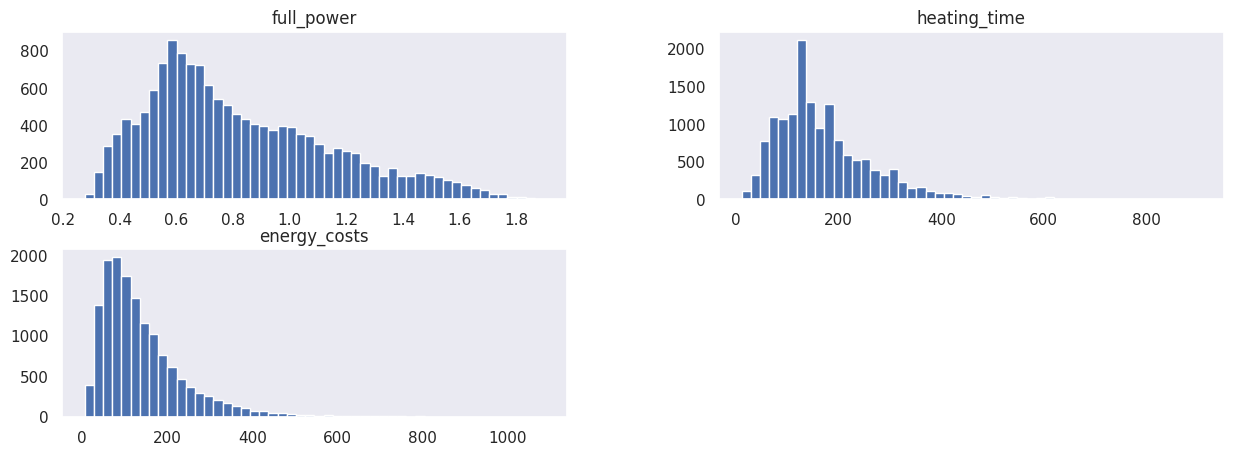

In [17]:
arc[['full_power', 'heating_time', 'energy_costs']].hist(figsize=(15,5), grid=False, bins=50)
plt.show()

По всей видимости, аномалия в столбце "время нагрева дугой". Посмотрим на боксплоте.

In [18]:
arc[['full_power','heating_time', 'energy_costs']].describe()

full_power  heating_time  energy_costs
count  14875.000000  14875.000000  14875.000000
mean       0.823385    171.675160    141.646999
std        0.323470     98.188759    103.200377
min        0.275718     11.000000      6.409531
25%        0.578839    107.000000     71.153177
50%        0.746554    147.000000    114.480842
75%        1.030402    214.000000    181.350568
max        1.898158    907.000000   1084.729420

Аномалий нет, можно переходить к агрегации. Сначала удалим столбцы начала нагрева и окончания нагрева - в них нет необходимости, поскольку у нас рассчитано время нагрева. Также удалим столбцы активной и реактивной мощности, они нам в дальнейшем не понадобятся, поскольку была рассчитана полная мощность по каждому циклу нагрева. Затем агрегируем данные по ключу.

In [19]:
arc.drop(['heating_start', 'heating_end', 'active_power', 'reactive_power'], axis= 1 , inplace= True )
# контроль
arc.head()

key  full_power  heating_time  energy_costs
0    1    0.371123           228     84.616003
1    1    0.902319           185    166.928978
2    1    0.722536           172    124.276277
3    1    0.642824           365    234.630603
4    1    1.079934           148    159.830252

In [20]:
arc_columns = {
    'key'            : 'count',
    'full_power'    : 'sum',
    'heating_time' : 'sum',
    'energy_costs' : 'sum'
}
arc = arc.groupby('key').agg(arc_columns).rename(columns={'key':'num_heating_cycles'})
# контроль
arc.head()

num_heating_cycles  full_power  heating_time  energy_costs
key                                                            
1                     5    3.718736          1098    770.282114
2                     4    2.588349           811    481.760005
3                     5    5.019223           655    722.837668
4                     4    3.400038           741    683.455597
5                     4    2.816980           869    512.169934

In [21]:
arc.describe()

num_heating_cycles   full_power  heating_time  energy_costs
count         3214.000000  3214.000000   3214.000000   3214.000000
mean             4.628189     3.810779    794.545115    655.569107
std              1.608866     1.502804    332.491076    308.976732
min              1.000000     0.331897     57.000000     33.430208
25%              4.000000     2.775306    571.000000    444.626580
50%              4.000000     3.694219    770.000000    620.101427
75%              6.000000     4.696915    983.000000    827.671845
max             16.000000    15.288271   4189.000000   4546.405812

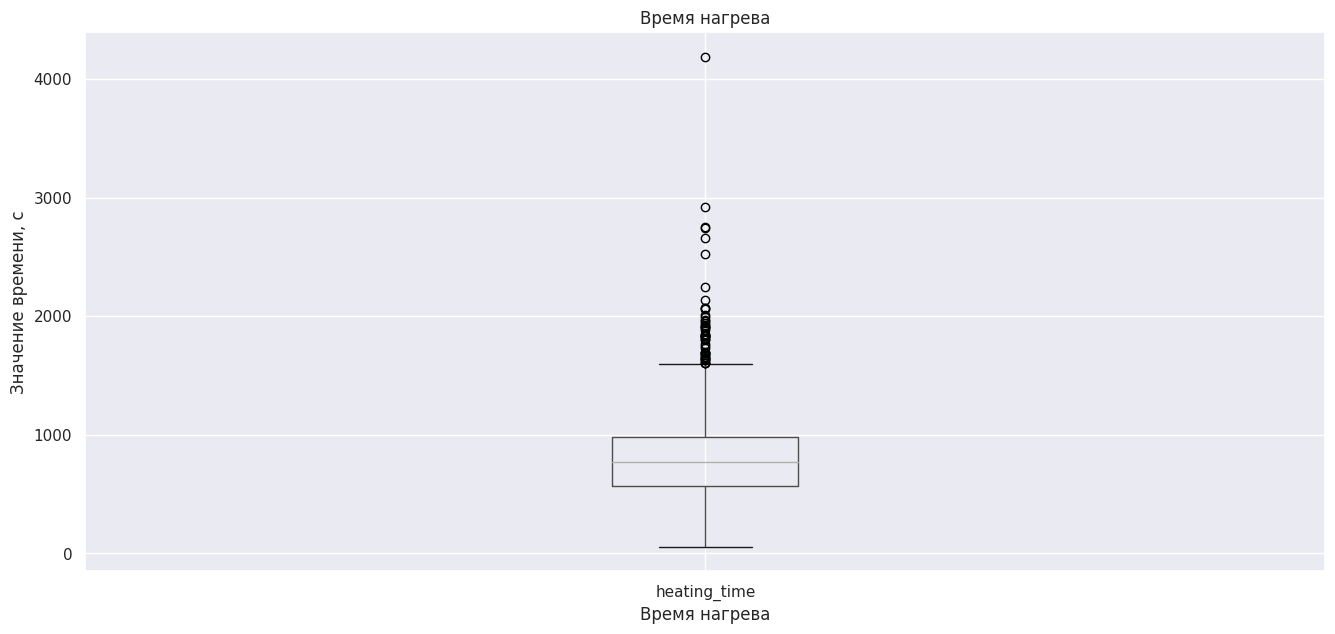

In [22]:
arc[['heating_time']].boxplot(figsize=(16, 7))
plt.title('Время нагрева')
plt.ylabel('Значение времени, с')
plt.xlabel('Время нагрева')
plt.show()

Аномалия в значении 4189. Удалим ее.

In [23]:
arc = arc.loc[arc['heating_time'] != 4189.000000]

# Контроль
arc.describe()

num_heating_cycles   full_power  heating_time  energy_costs
count         3213.000000  3213.000000   3213.000000   3213.000000
mean             4.624961     3.807207    793.488640    654.358141
std              1.598672     1.489328    327.102955    301.300073
min              1.000000     0.331897     57.000000     33.430208
25%              4.000000     2.775215    571.000000    444.547272
50%              4.000000     3.693903    770.000000    620.091715
75%              6.000000     4.695378    983.000000    827.333536
max             16.000000    14.466533   2919.000000   2380.879281

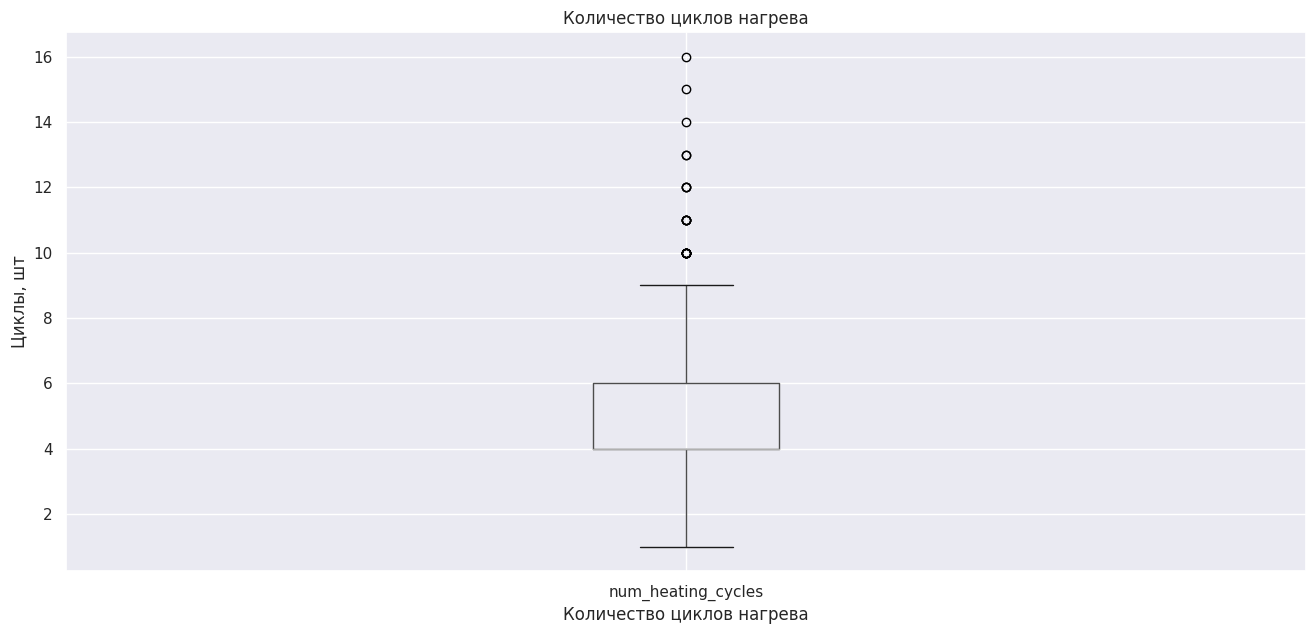

In [24]:
arc[['num_heating_cycles']].boxplot(figsize=(16, 7))
plt.title('Количество циклов нагрева')
plt.ylabel('Циклы, шт')
plt.xlabel('Количество циклов нагрева')
plt.show()

Аномалий нет, есть редко встречающиеся значения.

Вывод по шагу:
- Обнаружена аномалия в области отрицательных значений мощности. Восстановить верные данные не представляется возможным, ключ удален.
- После удаления наблюдаем распределение мощностей, похожее на распределение Пуассона со сдвигом влево. Аномалий нет.
- Рассчитано общее время нагрева по каждому циклу, полная мощность а также затраты электроэнергии
- Произведено удаление неактуальных столбцов: время начала нагрева, время конца нагрева, активная мощность, реактивная мощность
- Произведена агрегация столбцов по ключу с расчетом количества циклов нагрева.
- После агрегации удалена появившаяся аномалия в высоких значениях (4189) в столбце `heating_time`

### data_bulk_new: обработка данных и исследовательский анализ датасета

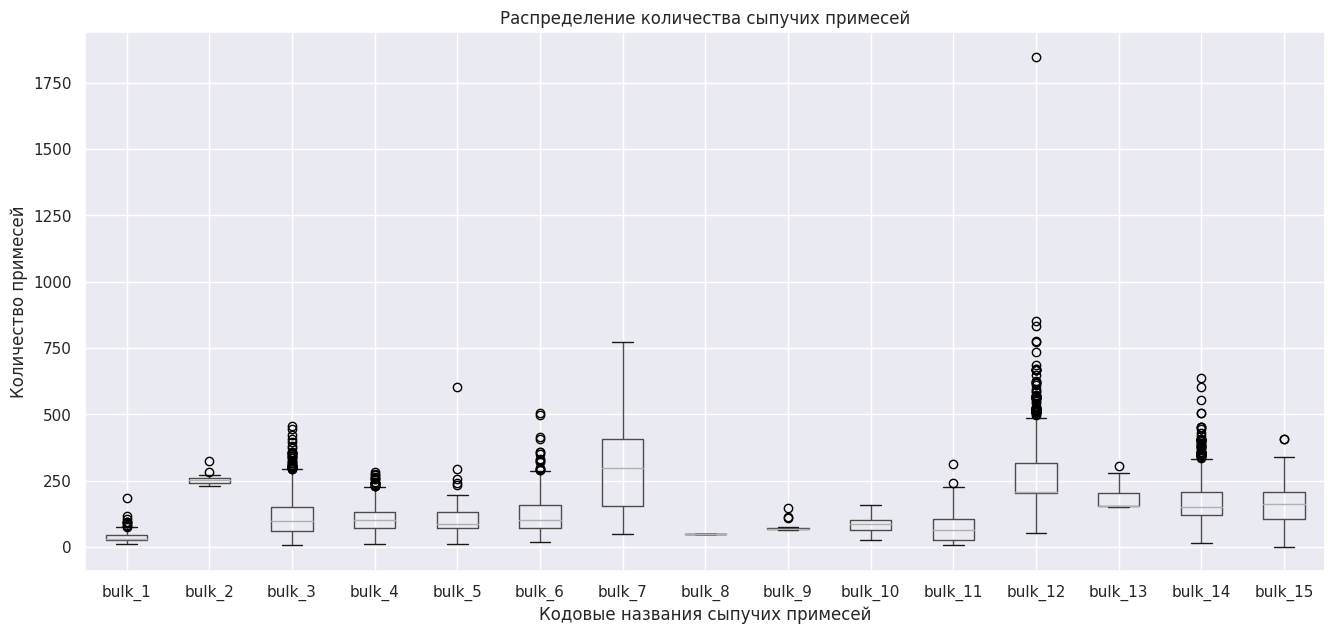

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          bulk_11      bulk_12     bulk_13      bulk_14      bulk_15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [25]:
# анализ использования сыпучих примесей
bulk.loc[:, 'bulk_1':'bulk_15'].boxplot(figsize=(16, 7))
plt.title('Распределение количества сыпучих примесей')
plt.ylabel('Количество примесей')
plt.xlabel('Кодовые названия сыпучих примесей')
plt.show()

bulk.describe()

Обнаружена явная аномалия в значении 603 для сыпучей примеси bulk_5. Обнаружена явная аномалия в значении 1849 для сыпучей примеси bulk_12.\
Также обнаружено, что примесь bulk_8 использовалась только лодин раз. На основании одного использования невозможно рассчитать закономерности. Этот ключ нужно будет удалить.
**Важно** Ключ удаляем целиком, а не просто удалим столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, сначала удалим строку, затем уже столбец.

In [26]:
bulk = bulk.loc[bulk['bulk_8'] != 49.0]

# Контроль
print(bulk.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1297 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   0 non-null      float64
 9   bulk_9   18 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB
None


In [27]:
# теперь можно удалить столбец bulk_8
bulk.drop('bulk_8', axis=1, inplace=True)
bulk_time.drop('bulk_8', axis=1, inplace=True)

# контроль
display(bulk.info())
display(bulk_time.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3128 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1297 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_9   18 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 391.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_9   19 non-null     datetime64[ns]
 9   bulk_10  176 non-null    datetime64[ns]
 10  bulk_11  177 non-null    datetime64[ns]
 11  bulk_12  2450 non-null   datetime64[ns]
 12  bulk_13  18 non-null     datetime64[ns]
 13  bulk_14  2806 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](14), int64(1)
memory usage: 366.8 KB


None

In [28]:
bulk = bulk.loc[bulk['bulk_5'] != 603.0]
bulk = bulk.loc[bulk['bulk_12'] != 1849.0]
# Контроль
bulk.describe()

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3126.000000  251.000000   22.000000  1295.000000  1012.000000   
mean   1624.689699   38.661355  253.045455   113.795367   104.513834   
std     933.484549   15.814198   21.180578    75.505319    48.152729   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.250000   27.000000  242.000000    57.500000    72.000000   
50%    1621.500000   31.000000  251.500000    97.000000   102.000000   
75%    2431.750000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  118.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7      bulk_9     bulk_10     bulk_11  \
count   76.000000  576.000000   24.000000   18.000000  176.000000  177.000000   
mean   100.500000  118.925347  301.416667   72.388889   83.284091   76.819209   
std     58.786733   72.057776  193.958067   13.759014   26.060347   59.655365   
min     11.000000   17.000000   47.000000   63.000000   24.000000    8.000000   
25%     70.000000   69.750000  143.250000   66.000000   64.000000   25.000000   
50%     85.000000  100.000000  297.000000   68.000000   86.500000   64.000000   
75%    132.000000  157.000000  419.250000   70.000000  102.000000  106.000000   
max    293.000000  503.000000  772.000000  111.000000  159.000000  313.000000   

           bulk_12     bulk_13      bulk_14      bulk_15  
count  2448.000000   18.000000  2804.000000  2247.000000  
mean    259.842729  181.111111   170.144080   160.538496  
std     116.342062   46.088009    65.288317    51.763102  
min      53.000000  151.000000    16.000000     1.000000  
25%     204.000000  153.250000   119.000000   105.000000  
50%     208.000000  155.500000   151.000000   160.000000  
75%     316.000000  203.500000   205.250000   205.000000  
max     853.000000  305.000000   601.000000   405.000000

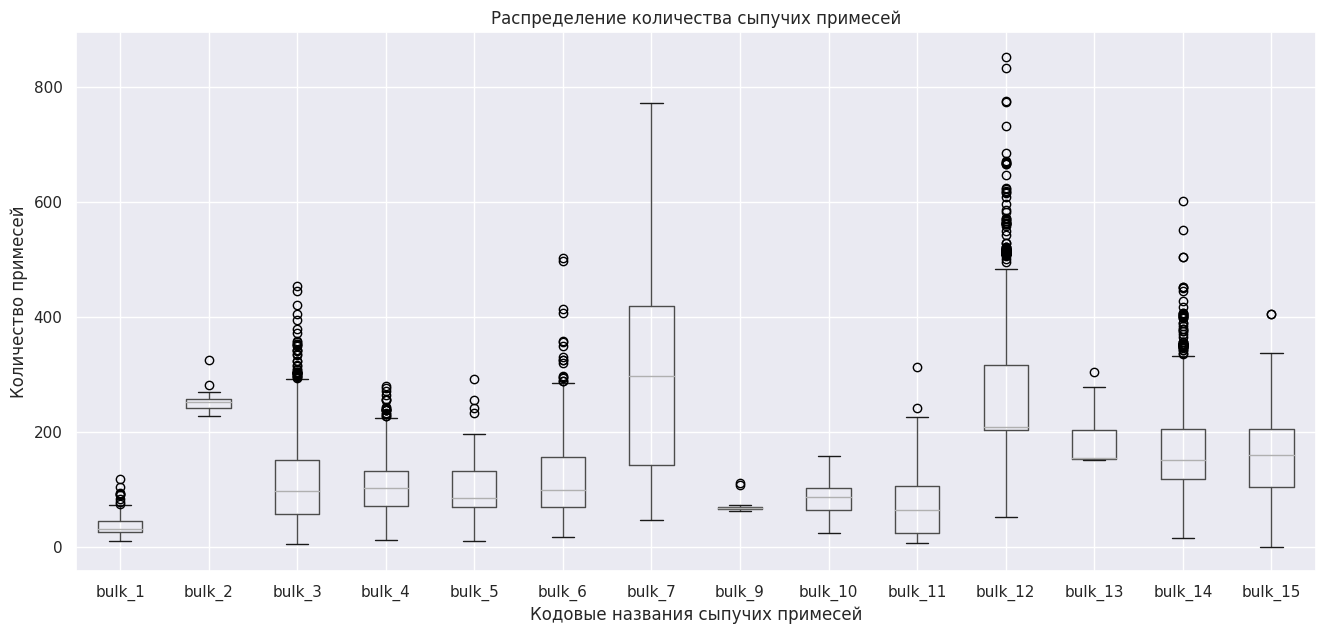

In [29]:
# И опять посмотрим распределения:
bulk.loc[:, 'bulk_1':'bulk_15'].boxplot(figsize=(16, 7))
plt.title('Распределение количества сыпучих примесей')
plt.ylabel('Количество примесей')
plt.xlabel('Кодовые названия сыпучих примесей')
plt.show()

Введем дополнительный признак "сумма внесенных примесей" `bulk_sum`. Предварительно заполним пропуски нулями

In [30]:
bulk = bulk.fillna(0)
bulk['bulk_sum'] = bulk.sum(axis=1)
bulk = bulk.astype(int)
display(bulk.head(10).style.background_gradient(cmap='Blues', axis=0))
#.hide_index()) - не сработало в колабе

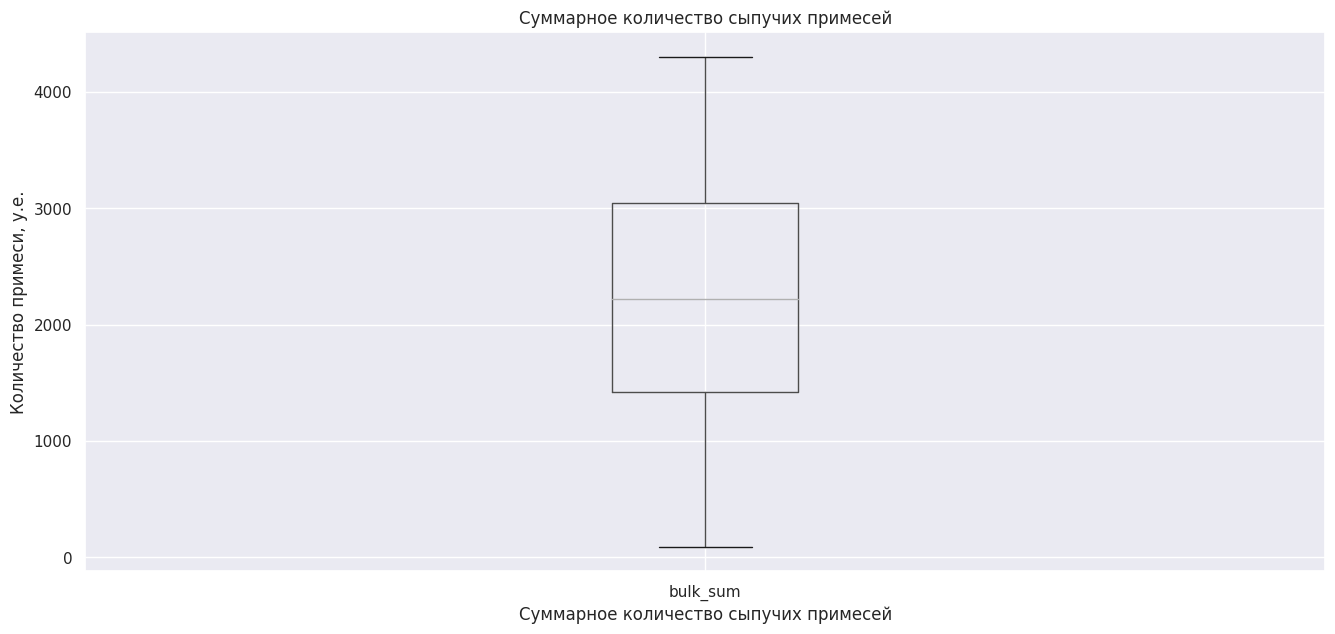

In [31]:
bulk[['bulk_sum']].boxplot(figsize=(16, 7))
plt.title('Суммарное количество сыпучих примесей')
plt.ylabel('Количество примеси, у.е.')
plt.xlabel('Суммарное количество сыпучих примесей')
plt.show()

Аномалий нет

**Вывод по шагу:**
- Обнаружен и удален явный выброс в значении 603 для сыпучей примеси bulk_5.
- Обнаружен и удален явный выброс в значении 1849 для сыпучей примеси bulk_12.
- Обнаружено, что примесь bulk_8 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. Удален этот ключ и затем удален столбец bulk_8. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, удален и ключ тоже
- Добавлен дополнительный столбец с суммарным количеством примесей `bulk_sum`
- Пропуски заполнены значениями 0

### data_bulk_time_new: обработка данных и исследовательский анализ датасета

In [32]:
bulk_time.head()

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_9  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15  
0 2019-05-03 11:10:43  
1 2019-05-03 11:44:39  
2 2019-05-03 12:16:16  
3 2019-05-03 12:46:36  
4 2019-05-03 13:30:47

In [33]:
bulk_time['max_time'] = bulk_time.loc[:,'bulk_1' : 'bulk_15'].max(axis=1)
bulk_time['min_time'] = bulk_time.loc[:,'bulk_1' : 'bulk_15'].min(axis=1)
bulk_time['time'] = (bulk_time['max_time'] - bulk_time['min_time']).astype('timedelta64[s]').astype('int')
bulk_time.head()

key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_9  \
0    1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

  bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50   
1     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
2     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
3     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   
4     NaT     NaT 2019-05-03 13:30:47     NaT 2019-05-03 13:34:12   

              bulk_15            max_time            min_time  time  
0 2019-05-03 11:10:43 2019-05-03 11:28:48 2019-05-03 11:10:43  1085  
1 2019-05-03 11:44:39 2019-05-03 11:53:30 2019-05-03 11:36:50  1000  
2 2019-05-03 12:16:16 2019-05-03 12:32:39 2019-05-03 12:16:16   983  
3 2019-05-03 12:46:36 2019-05-03 12:58:00 2019-05-03 12:43:22   878  
4 2019-05-03 13:30:47 2019-05-03 13:34:12 2019-05-03 13:30:47   205

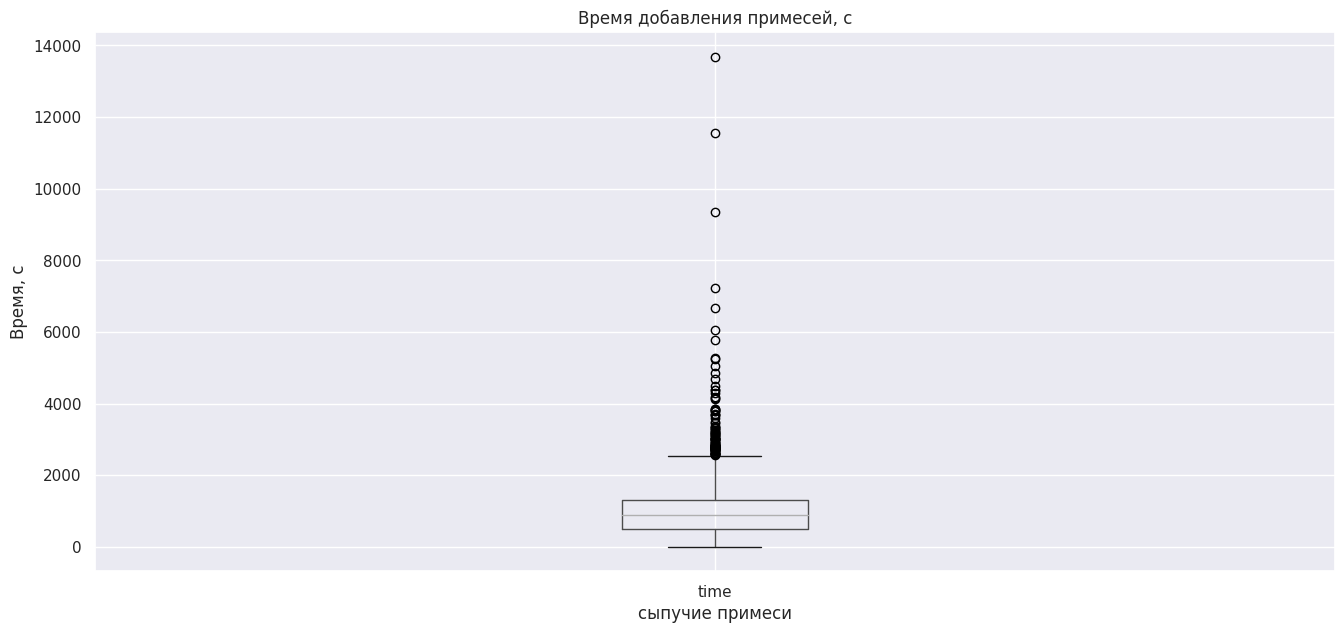

time
count   3129.000000
mean     964.906679
std      798.088025
min        0.000000
25%      485.000000
50%      877.000000
75%     1311.000000
max    13683.000000

In [34]:
bulk_time[['time']].boxplot(figsize=(16, 7))
plt.title('Время добавления примесей, с')
plt.ylabel('Время, с')
plt.xlabel('сыпучие примеси')
plt.show()

bulk_time[['time']].describe()

Обнаружены аномалии в высоких знаечниях > 9000 с (2,5 часа). Удалим их.

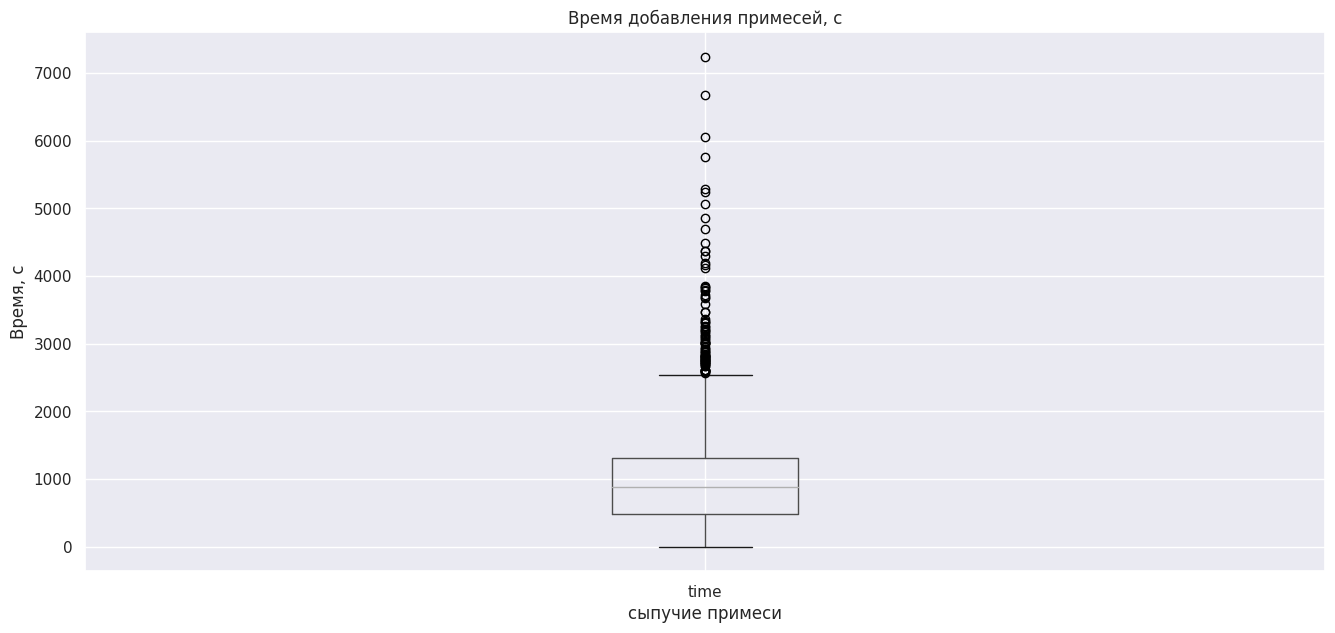

key                         bulk_1  \
count  3126.000000                            252   
mean   1624.112924  2019-06-29 23:24:44.769841152   
min       1.000000            2019-05-03 17:42:46   
25%     815.250000     2019-05-29 14:48:48.500000   
50%    1620.500000            2019-06-25 11:09:13   
75%    2431.750000  2019-07-31 05:58:18.249999872   
max    3241.000000            2019-09-05 09:11:32   
std     933.743947                            NaN   

                              bulk_2                         bulk_3  \
count                             22                           1295   
mean   2019-07-12 07:57:13.045454592  2019-07-08 13:27:00.497297152   
min              2019-05-07 15:39:35            2019-05-03 20:40:25   
25%       2019-05-28 02:29:31.500000            2019-06-08 00:37:30   
50%       2019-07-27 17:18:38.500000            2019-07-04 08:19:42   
75%              2019-08-13 02:20:08            2019-08-11 01:49:51   
max              2019-08-13 11:47:39            2019-09-06 12:26:52   
std                              NaN                            NaN   

                              bulk_4                         bulk_5  \
count                           1014                             77   
mean   2019-07-03 11:17:28.834319616  2019-07-13 17:18:29.090908928   
min              2019-05-03 11:28:48            2019-05-07 15:19:17   
25%    2019-05-30 21:36:11.249999872            2019-06-19 23:32:44   
50%       2019-06-28 03:44:42.500000            2019-07-25 17:59:41   
75%       2019-08-04 04:15:46.500000            2019-08-13 04:23:23   
max              2019-09-05 03:35:21            2019-09-02 18:16:52   
std                              NaN                            NaN   

                              bulk_6                         bulk_7  \
count                            573                             25   
mean   2019-07-06 12:42:32.848167424  2019-07-27 18:09:05.079999744   
min              2019-05-03 19:09:15            2019-05-07 18:11:01   
25%              2019-06-06 11:51:00            2019-07-20 23:48:47   
50%              2019-07-07 23:05:10            2019-07-27 18:07:02   
75%              2019-08-07 19:14:08            2019-08-13 04:19:43   
max              2019-09-06 16:24:28            2019-09-05 19:07:49   
std                              NaN                            NaN   

                              bulk_9                        bulk_10  \
count                             19                            176   
mean   2019-06-23 08:08:47.578947072  2019-07-06 23:55:10.954545408   
min              2019-05-14 11:57:58            2019-05-06 07:54:02   
25%              2019-05-14 14:31:08     2019-06-02 05:12:00.500000   
50%              2019-05-14 16:55:09            2019-07-06 07:05:20   
75%              2019-08-16 05:43:31  2019-08-04 02:23:35.750000128   
max              2019-08-16 09:11:56            2019-09-04 10:03:22   
std                              NaN                            NaN   

                             bulk_11                        bulk_12  \
count                            175                           2447   
mean   2019-07-15 07:47:22.005714176  2019-07-05 22:38:20.259092992   
min              2019-05-05 23:43:24            2019-05-03 11:24:31   
25%       2019-06-14 16:57:50.500000            2019-06-03 12:21:54   
50%              2019-07-24 11:57:35            2019-07-02 22:34:40   
75%       2019-08-11 05:42:44.500000     2019-08-08 15:54:20.500000   
max              2019-09-06 05:03:14            2019-09-06 15:01:44   
std                              NaN                            NaN   

                             bulk_13                        bulk_14  \
count                             18                           2803   
mean   2019-07-01 18:32:46.944444416  2019-07-06 07:03:41.503032320   
min              2019-05-05 02:10:21            2019-05-03 11:14:50   
25%    2019-05-29 10:43:31.249999872            2019-

In [35]:
bulk_time = bulk_time.loc[bulk_time['time'] < 8000]

# Контроль
bulk_time[['time']].boxplot(figsize=(16, 7))
plt.title('Время добавления примесей, с')
plt.ylabel('Время, с')
plt.xlabel('сыпучие примеси')
plt.show()
bulk_time.describe()

Вывод по шагу:
- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 2,5 часов)

### data_gas_new: обработка данных и исследовательский анализ датасета data_gas_new

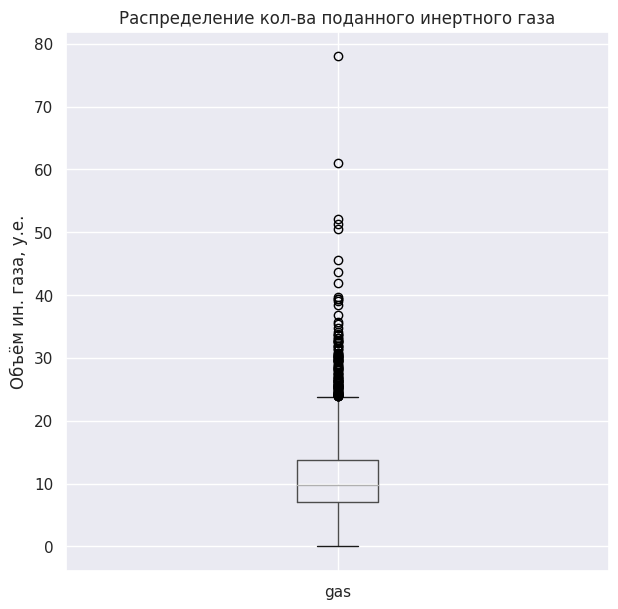

gas
count  3239.000000
mean     11.002062
std       6.220327
min       0.008399
25%       7.043089
50%       9.836267
75%      13.769915
max      77.995040

In [36]:
# распределение кол-ва ин.газа
gas.boxplot('gas', figsize=(7, 7))
plt.title('Распределение кол-ва поданного инертного газа')
plt.ylabel('Объём ин. газа, у.е.')
plt.show()

gas['gas'].describe().to_frame()

Значения  в районе 61 и 78 выглядят как аномалии, однако, вполне возможно, такое большое количество газа потребовалось для партий, где было больше всего циклов нагрева. Предположим, что это редкие значения и оставим их.

### data_temp_new: обработка данных и исследовательский анализ датасета

In [37]:
# замеры температуры
temp_na_index = temp[temp['temp'].isna()].index
print('Пропуски до удаления ключей:')
display(temp.loc[temp_na_index])
print(len(temp.loc[temp_na_index, 'key'].unique()), 'партий с отсутствующими замерами температур.\n')
temp.drop(temp_na_index, inplace=True)
temp['temp'] = temp['temp'].astype('int64')

# контроль
print('Наличие пропусков после очистки:')
display(temp[temp['temp'].isna()])

Пропуски до удаления ключей:


key                time  temp
13927  2500 2019-08-10 14:13:11  <NA>
13928  2500 2019-08-10 14:18:12  <NA>
13929  2500 2019-08-10 14:25:53  <NA>
13930  2500 2019-08-10 14:29:39  <NA>
13932  2501 2019-08-10 14:49:15  <NA>
...     ...                 ...   ...
18087  3241 2019-09-06 16:55:01  <NA>
18088  3241 2019-09-06 17:06:38  <NA>
18089  3241 2019-09-06 17:21:48  <NA>
18090  3241 2019-09-06 17:24:44  <NA>
18091  3241 2019-09-06 17:30:05  <NA>

[3427 rows x 3 columns]

739 партий с отсутствующими замерами температур.

Наличие пропусков после очистки:


Empty DataFrame
Columns: [key, time, temp]
Index: []

In [38]:
display(temp.describe())

key                           time          temp
count  14665.000000                          14665  14665.000000
mean    1325.484214  2019-06-23 23:59:11.606341632   1590.722741
min        1.000000            2019-05-03 11:02:04   1191.000000
25%      654.000000            2019-05-28 23:56:49   1580.000000
50%     1314.000000            2019-06-21 22:55:49   1590.000000
75%     1963.000000            2019-07-21 22:58:20   1599.000000
max     3241.000000            2019-09-06 16:48:55   1705.000000
std      787.375969                            NaN     20.394381

In [39]:
temp.tail()

key                time  temp
18061  3237 2019-09-06 11:31:15  1569
18067  3238 2019-09-06 12:16:15  1584
18071  3239 2019-09-06 14:16:50  1598
18080  3240 2019-09-06 15:25:21  1617
18086  3241 2019-09-06 16:48:55  1586

**Теперь нужно удалить данные, где по одному ключу только один замер температуры**

In [40]:
temp_time = temp
temp_time['start_time'] = temp_time['time']
temp_time['last_time'] = temp_time['time']
temp_time_columns = {'start_time' : 'first', 'last_time' : 'last'}
temp_time = temp_time.groupby('key').agg(temp_time_columns)

temp_time.tail()

start_time           last_time
key                                         
3237 2019-09-06 11:31:15 2019-09-06 11:31:15
3238 2019-09-06 12:16:15 2019-09-06 12:16:15
3239 2019-09-06 14:16:50 2019-09-06 14:16:50
3240 2019-09-06 15:25:21 2019-09-06 15:25:21
3241 2019-09-06 16:48:55 2019-09-06 16:48:55

In [41]:
temp_time['diff'] = (temp_time['last_time'] - temp_time['start_time']).astype(int)
result = temp_time[temp_time['diff']==0]
result

start_time           last_time  diff
key                                               
195  2019-05-11 00:01:36 2019-05-11 00:01:36     0
279  2019-05-14 10:13:01 2019-05-14 10:13:01     0
2500 2019-08-10 14:04:39 2019-08-10 14:04:39     0
2501 2019-08-10 14:41:14 2019-08-10 14:41:14     0
2502 2019-08-10 15:39:39 2019-08-10 15:39:39     0
...                  ...                 ...   ...
3237 2019-09-06 11:31:15 2019-09-06 11:31:15     0
3238 2019-09-06 12:16:15 2019-09-06 12:16:15     0
3239 2019-09-06 14:16:50 2019-09-06 14:16:50     0
3240 2019-09-06 15:25:21 2019-09-06 15:25:21     0
3241 2019-09-06 16:48:55 2019-09-06 16:48:55     0

[741 rows x 3 columns]

In [42]:
result=result.reset_index()
result=result['key']
result

0       195
1       279
2      2500
3      2501
4      2502
       ... 
736    3237
737    3238
738    3239
739    3240
740    3241
Name: key, Length: 741, dtype: int64

In [43]:
for res in result:
    temp = temp.loc[temp['key'] !=res]

In [44]:
temp.tail()

key                time  temp          start_time           last_time
13921  2499 2019-08-10 13:33:21  1569 2019-08-10 13:33:21 2019-08-10 13:33:21
13922  2499 2019-08-10 13:41:34  1604 2019-08-10 13:41:34 2019-08-10 13:41:34
13923  2499 2019-08-10 13:46:28  1593 2019-08-10 13:46:28 2019-08-10 13:46:28
13924  2499 2019-08-10 13:54:56  1588 2019-08-10 13:54:56 2019-08-10 13:54:56
13925  2499 2019-08-10 13:58:58  1603 2019-08-10 13:58:58 2019-08-10 13:58:58

Температура нагрева по регламенту не должна опускаться ниже 1500 градусов. Удалим ключи со значением температуры ниже 1500С

In [45]:
temp['start_temp'] = temp['temp']
temp['min_temp'] = temp['temp']
temp['last_temp'] = temp['temp']
temp_columns = {
    'start_temp' : 'first',
    'min_temp' : 'min',
    'last_temp' : 'last'}
temp = temp.groupby('key').agg(temp_columns)

temp = temp.loc[temp['min_temp'] > 1500]
display(temp.head(10).style.background_gradient(cmap='Blues', axis=0))

А теперь удалим столбец минимальной температуры, поскольку в дальнейшем он повлечет за собой утечку данных.

In [46]:
temp = temp.drop('min_temp', axis = 1)
temp

start_temp  last_temp
key                        
1           1571       1613
2           1581       1602
3           1596       1599
4           1601       1625
5           1576       1602
...          ...        ...
2495        1570       1591
2496        1554       1591
2497        1571       1589
2498        1591       1594
2499        1569       1603

[2471 rows x 2 columns]

In [47]:
# контроль
display(temp.describe())
display(temp.info())

start_temp    last_temp
count  2471.000000  2471.000000
mean   1589.012950  1595.339943
std      25.004369    16.035215
min    1519.000000  1541.000000
25%    1572.000000  1587.000000
50%    1588.000000  1593.000000
75%    1605.000000  1599.000000
max    1679.000000  1700.000000

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   start_temp  2471 non-null   int64
 1   last_temp   2471 non-null   int64
dtypes: int64(2)
memory usage: 57.9 KB


None

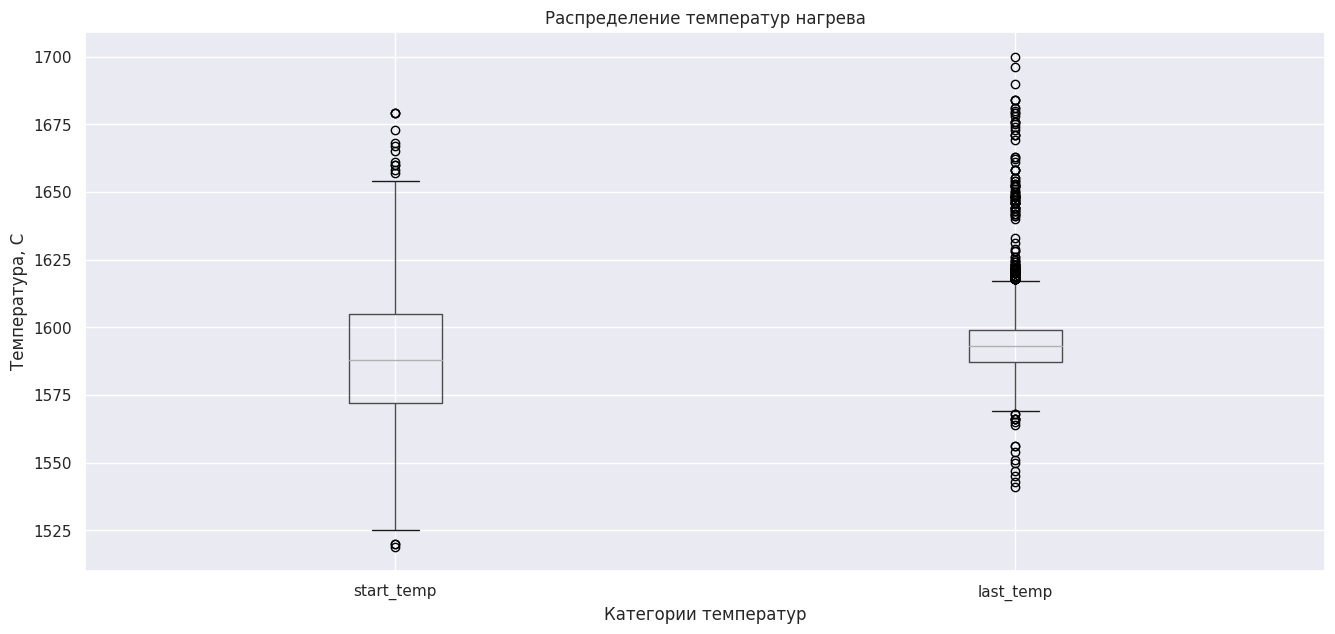

start_temp    last_temp
count  2471.000000  2471.000000
mean   1589.012950  1595.339943
std      25.004369    16.035215
min    1519.000000  1541.000000
25%    1572.000000  1587.000000
50%    1588.000000  1593.000000
75%    1605.000000  1599.000000
max    1679.000000  1700.000000

In [48]:
# распределение температуры

temp.loc[:, 'start_temp':'last_temp'].boxplot(figsize=(16, 7))
plt.title('Распределение температур нагрева')
plt.ylabel('Температура, С')
plt.xlabel('Категории температур')
plt.show()

temp.loc[:, 'start_temp':'last_temp'].describe()



Вывод по шагу:
- Удалены пропуски в датасете температур,
- Удалены ключи с температурами ниже 1500С (по регламенту должно быть не ниже этого значения),
- Агрегированы данные - одна колонка температур преобразована в две колонки по ключам: начальная температура, конечная температура. Промежуточные значения температур удалены.
    

### data_wire_new: обработка данных и исследовательский анализ датасета

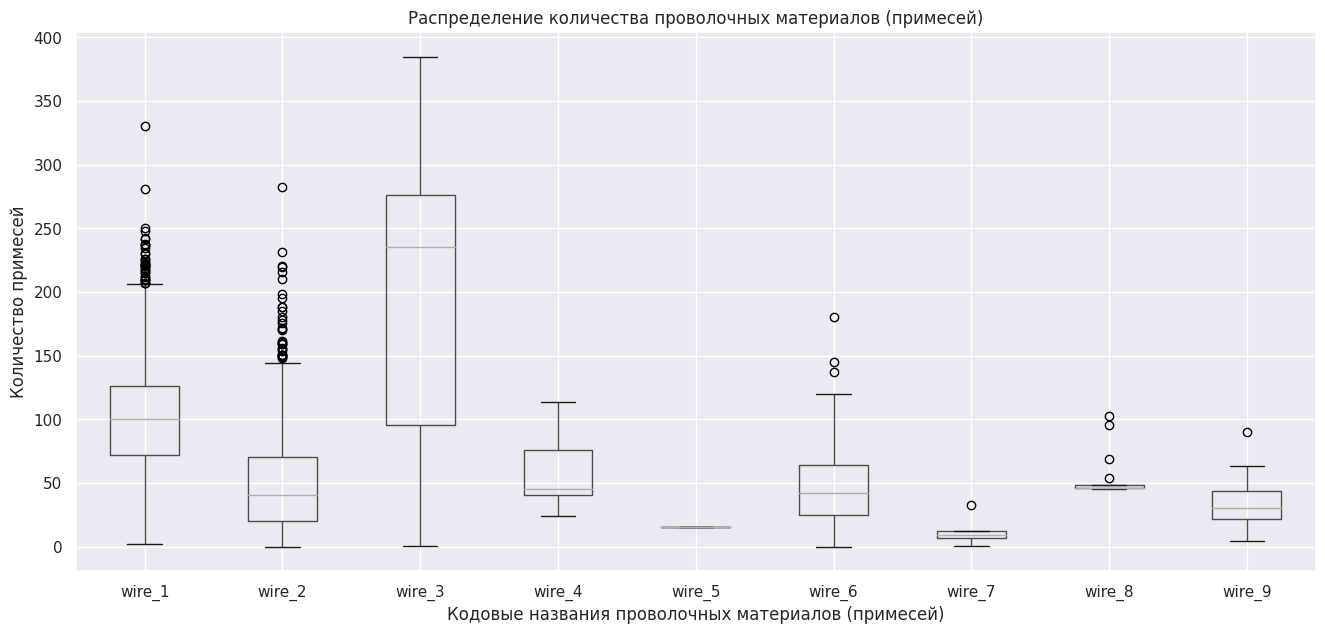

key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           wire_6     wire_7      wire_8     wire_9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [49]:
# анализ использования сыпучих примесей
wire.loc[:, 'wire_1':'wire_9'].boxplot(figsize=(16, 7))
plt.title('Распределение количества проволочных материалов (примесей)')
plt.ylabel('Количество примесей')
plt.xlabel('Кодовые названия проволочных материалов (примесей)')
plt.show()

wire.describe()

Аномалий не обнаружено.
Обнаружено, что примесь wire_5 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. Этот ключ нужно будет удалить. **Важно** Ключ удаляем целиком, а не просто удалим столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, сначала удалим строку, затем уже столбец.

In [50]:
wire = wire.loc[wire['wire_5'] != 15.132]

# Контроль
print(wire.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3080 non-null   int64  
 1   wire_1  3054 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  62 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  0 non-null      float64
 6   wire_6  72 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 264.7 KB
None


In [51]:
# теперь можно удалить столбец bulk_8
wire.drop('wire_5', axis=1, inplace=True)
wire_time.drop('wire_5', axis=1, inplace=True)

# контроль
display(wire.info())
display(wire_time.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3080 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3080 non-null   int64  
 1   wire_1  3054 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  62 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_6  72 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 240.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_6  73 non-null     datetime64[ns]
 6   wire_7  11 non-null     datetime64[ns]
 7   wire_8  19 non-null     datetime64[ns]
 8   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](8), int64(1)
memory usage: 216.8 KB


None

Введем дополнительный столбец "Сумма проволочных добавок" `wire_sum`. Предварительно заполним пропуски нулями.

In [52]:
wire = wire.fillna(0)
wire['wire_sum'] = wire.sum(axis=1)
wire = wire.astype(int)
display(wire.head(10).style.background_gradient(cmap='Blues', axis=0))
#.hide_index()) - не сработало в колаб

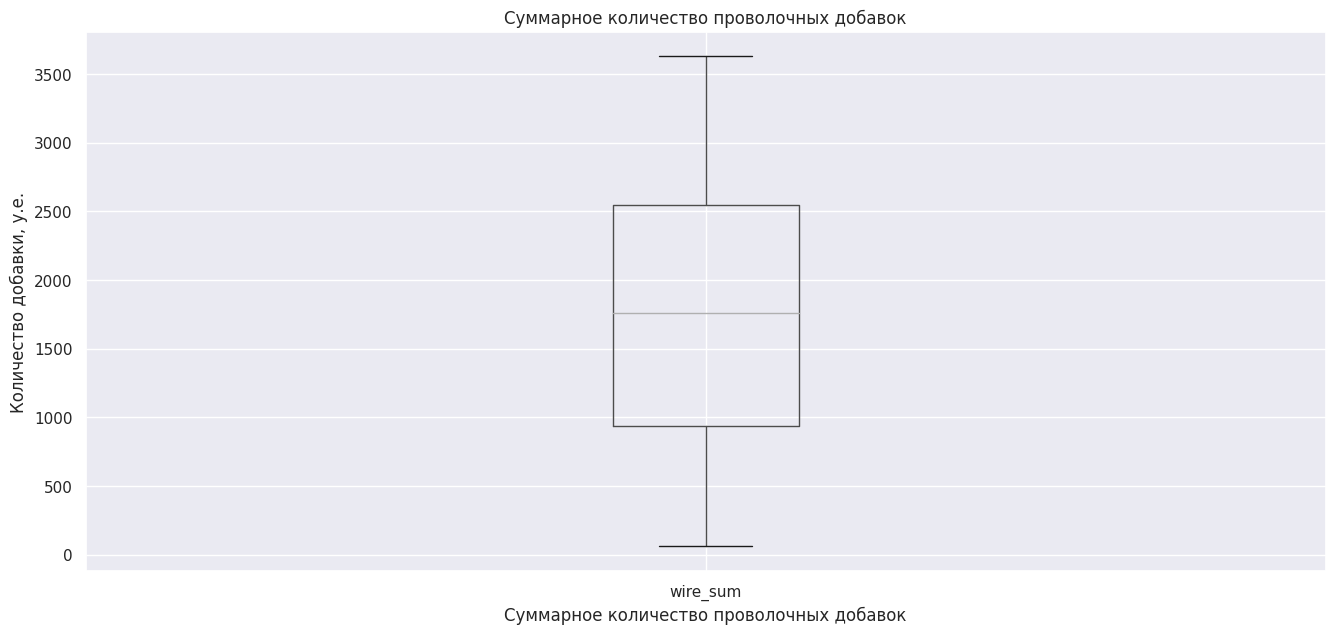

In [53]:
wire[['wire_sum']].boxplot(figsize=(16, 7))
plt.title('Суммарное количество проволочных добавок')
plt.ylabel('Количество добавки, у.е.')
plt.xlabel('Суммарное количество проволочных добавок')
plt.show()

Аномалий нет

**Вывод по шагу:**
- Аномалий не обнаружено.
- Обнаружено, что примесь wire_5 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, сначала удалена строка, затем уже столбец.
- Добавлен дополнительный столбец с суммарным количеством добавок `wire_sum`
- Пропуски заполнены значениями 0

### data_wire_time_new: обработка данных и исследовательский анализ датасета

In [54]:
wire_time.head()

key              wire_1              wire_2 wire_3 wire_4 wire_6 wire_7  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  wire_8 wire_9  
0    NaT    NaT  
1    NaT    NaT  
2    NaT    NaT  
3    NaT    NaT  
4    NaT    NaT

In [55]:
wire_time['max_time'] = wire_time.loc[:, 'wire_1' : 'wire_9'].max(axis=1)
wire_time['min_time'] = wire_time.loc[:, 'wire_1' : 'wire_9'].min(axis=1)
wire_time['time'] = (wire_time['max_time'] - wire_time['min_time']).astype('timedelta64[s]').astype('int')
wire_time.head()

key              wire_1              wire_2 wire_3 wire_4 wire_6 wire_7  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  wire_8 wire_9            max_time            min_time  time  
0    NaT    NaT 2019-05-03 11:06:19 2019-05-03 11:06:19     0  
1    NaT    NaT 2019-05-03 11:36:50 2019-05-03 11:36:50     0  
2    NaT    NaT 2019-05-03 12:11:46 2019-05-03 12:11:46     0  
3    NaT    NaT 2019-05-03 12:43:22 2019-05-03 12:43:22     0  
4    NaT    NaT 2019-05-03 13:20:44 2019-05-03 13:15:34   310

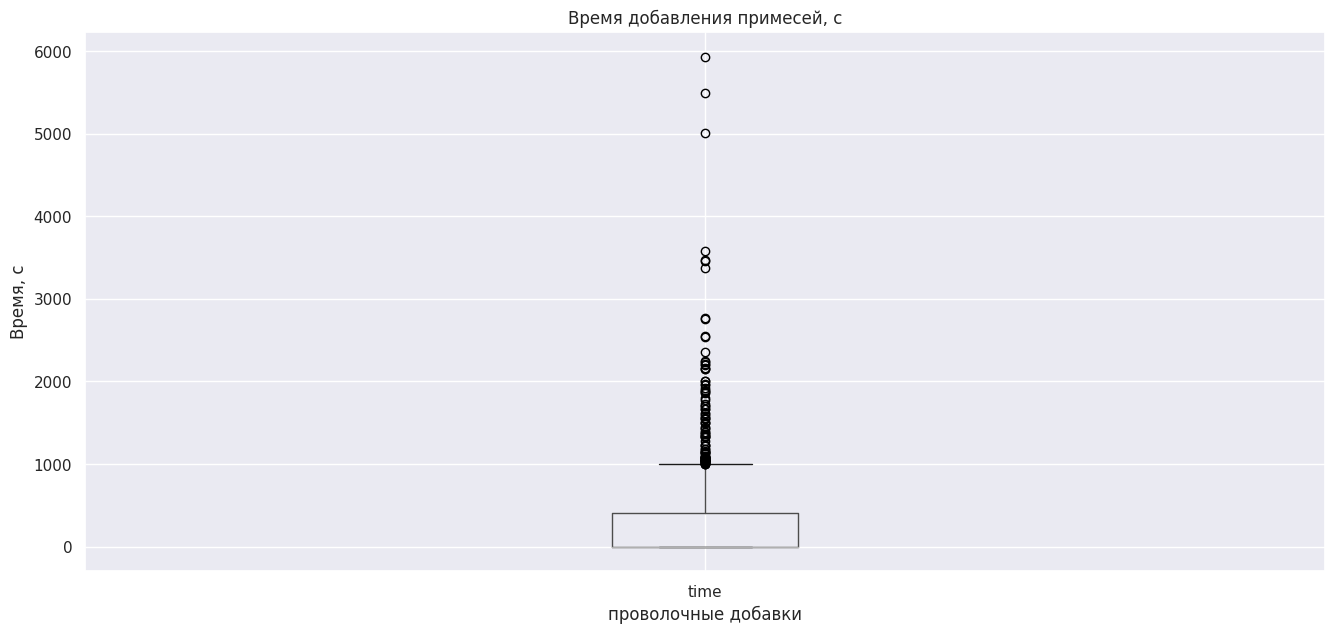

time
count  3081.000000
mean    214.519312
std     396.131967
min       0.000000
25%       0.000000
50%       0.000000
75%     401.000000
max    5937.000000

In [56]:
wire_time[['time']].boxplot(figsize=(16, 7))
plt.title('Время добавления примесей, с')
plt.ylabel('Время, с')
plt.xlabel('проволочные добавки')
plt.show()

wire_time[['time']].describe()

Обнаружены аномалии в высоких значениях (>4000 c). Удалим их.

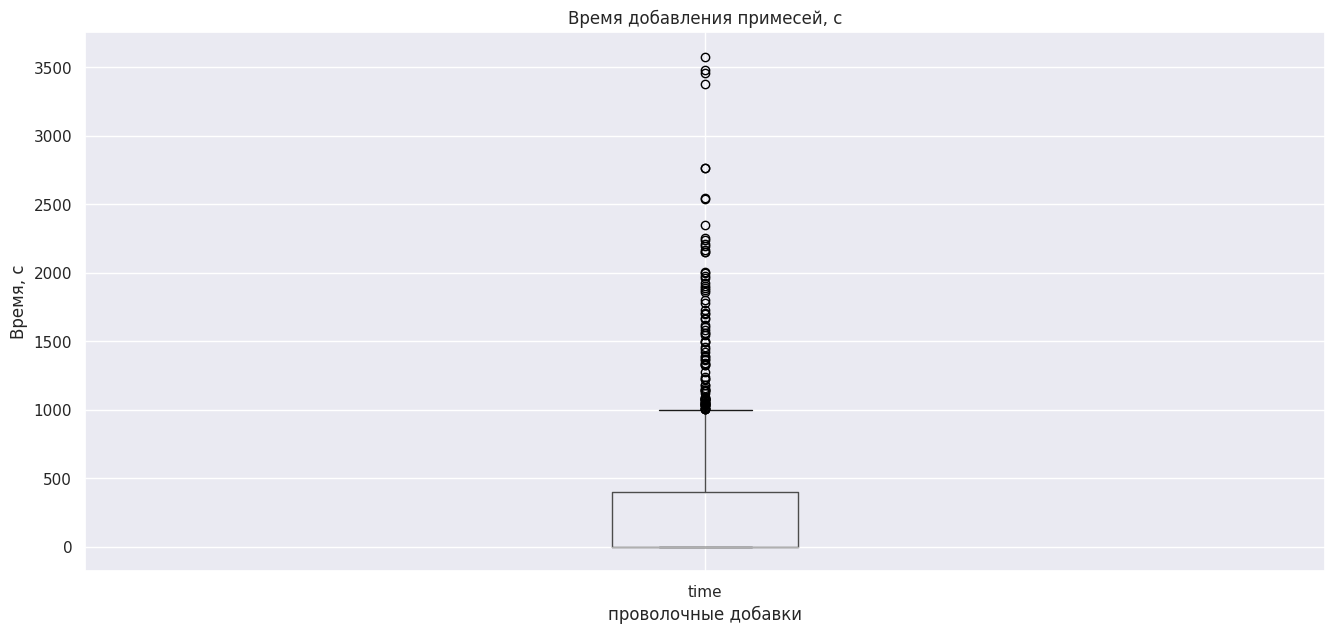

time
count  3078.000000
mean    209.386615
std     360.374880
min       0.000000
25%       0.000000
50%       0.000000
75%     399.750000
max    3578.000000

In [57]:
wire_time = wire_time.loc[wire_time['time'] < 4000]

# Контроль
wire_time[['time']].boxplot(figsize=(16, 7))
plt.title('Время добавления примесей, с')
plt.ylabel('Время, с')
plt.xlabel('проволочные добавки')
plt.show()

wire_time[['time']].describe()

Вывод по шагу:

- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 4000 с)

### Вывод
`data_arc_new.csv` — данные об электродах;
- Обнаружена аномалия в области отрицательных значений мощности. Восстановить верные данные не представляется возможным, ключ удален.
- После удаления наблюдаем распределение мощностей, похожее на распределение Пуассона со сдвигом влево. Аномалий нет.
- Рассчитано общее время нагрева по каждому циклу, полная мощность а также затраты электроэнергии
- Произведено удаление неактуальных столбцов: время начала нагрева, время конца нагрева, активная мощность, реактивная мощность
- Произведена агрегация столбцов по ключу с расчетом количества циклов нагрева.
- После агрегации удалена появившаяся аномалия в высоких значениях (4189) в столбце `heating_time`

`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- Обнаружена и удалена явная аномалия в значении 603 для сыпучей примеси bulk_5.
- Обнаружена и удалена явная аномалия в значении 1849 для сыпучей примеси bulk_12.
- Обнаружено, что примесь bulk_8 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. Удален этот ключ и затем удален столбец bulk_8. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, удален и ключ тоже
- Добавлен дополнительный столбец с суммарным количеством примесей `bulk_sum`
- Пропуски заполнены значениями 0

`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 2,5 часов)

`data_gas_new.csv` — данные о продувке сплава газом:
- Обнаружены редко встречающиеся значения ~61 и ~78, выглядящие как аномалии, однако, вполне возможно, такое большое количество газа потребовалось для партий, где было больше всего циклов нагрева. Значения не удалены из предположения. что это редкие значения.


`data_temp_new.csv` — результаты измерения температуры;
- Удалены пропуски в датасете температур,
- Удалены ключи с температурами ниже 1500С (по регламенту должно быть не ниже этого значения),
- Агрегированы данные - одна колонка температур преобразована в две колонки по ключам: начальная температура, конечная температура. Промежуточные значения температур удалены.


`data_wire_new.csv` — данные о проволочных материалах (объём);
- Аномалий не обнаружено.
- Обнаружено, что примесь wire_5 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, сначала удалена строка, затем уже столбец.
- Добавлен дополнительный столбец с суммарным количеством добавок `wire_sum`
- Пропуски заполнены значениями 0


`data_wire_time_new.csv` — данные о проволочных материалах (время).
- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 4000 с)

## Объединение данных

### Объединение таблиц

Датасеты `data_bulk_time_new` и `data_wire_time_new` в итоговую таблицу не пойдут: они были нужны для проверки корректности данных

In [58]:
datasets = {'data_arc_new' : arc,
            'data_bulk_new': bulk,
            'data_gas_new' : gas,
            'data_temp_new' : temp,
            'data_wire_new' : wire,
            }

for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.tail(2))
    display(dataset.info())
    #print('Партий:',len(dataset['key'].unique()))

data_arc_new
_____________________________________


num_heating_cycles  full_power  heating_time  energy_costs
key                                                             
3240                   5     4.08292           839    657.439848
3241                   5     3.72288           659    538.258300

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_heating_cycles  3213 non-null   int64  
 1   full_power          3213 non-null   float64
 2   heating_time        3213 non-null   int64  
 3   energy_costs        3213 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 125.5 KB


None

data_bulk_new
_____________________________________


key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
3127  3240       0       0       0       0       0      26       0       0   
3128  3241       0       0       0       0       0       0       0       0   

      bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  bulk_sum  
3127        0        0        0        0      192       54      3512  
3128        0        0        0        0      180       52      3473

<class 'pandas.core.frame.DataFrame'>
Index: 3126 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   key       3126 non-null   int64
 1   bulk_1    3126 non-null   int64
 2   bulk_2    3126 non-null   int64
 3   bulk_3    3126 non-null   int64
 4   bulk_4    3126 non-null   int64
 5   bulk_5    3126 non-null   int64
 6   bulk_6    3126 non-null   int64
 7   bulk_7    3126 non-null   int64
 8   bulk_9    3126 non-null   int64
 9   bulk_10   3126 non-null   int64
 10  bulk_11   3126 non-null   int64
 11  bulk_12   3126 non-null   int64
 12  bulk_13   3126 non-null   int64
 13  bulk_14   3126 non-null   int64
 14  bulk_15   3126 non-null   int64
 15  bulk_sum  3126 non-null   int64
dtypes: int64(16)
memory usage: 415.2 KB


None

data_gas_new
_____________________________________


key        gas
3237  3240  11.863103
3238  3241  12.680959

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

data_temp_new
_____________________________________


start_temp  last_temp
key                        
2498        1591       1594
2499        1569       1603

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   start_temp  2471 non-null   int64
 1   last_temp   2471 non-null   int64
dtypes: int64(2)
memory usage: 57.9 KB


None

data_wire_new
_____________________________________


key  wire_1  wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  \
3079  3240      34       0       0       0       0       0       0       0   
3080  3241      63       0       0       0       0       0       0       0   

      wire_sum  
3079      3274  
3080      3304

<class 'pandas.core.frame.DataFrame'>
Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   key       3080 non-null   int64
 1   wire_1    3080 non-null   int64
 2   wire_2    3080 non-null   int64
 3   wire_3    3080 non-null   int64
 4   wire_4    3080 non-null   int64
 5   wire_6    3080 non-null   int64
 6   wire_7    3080 non-null   int64
 7   wire_8    3080 non-null   int64
 8   wire_9    3080 non-null   int64
 9   wire_sum  3080 non-null   int64
dtypes: int64(10)
memory usage: 264.7 KB


None

In [59]:
# объединение данных
data = temp
data = data.join(arc, on='key', how='inner')
data = data.join(gas.set_index('key'), on='key', how='inner')
data = data.join(bulk.set_index('key'), on='key', how='inner')
data = data.join(wire.set_index('key'), on='key', how='inner')



In [60]:
data.tail()

start_temp  last_temp  num_heating_cycles  full_power  heating_time  \
key                                                                         
2495        1570       1591                   4    3.868721           723   
2496        1554       1591                   6    5.070316           940   
2497        1571       1589                   3    4.360918           569   
2498        1591       1594                   5    3.909917           750   
2499        1569       1603                   4    2.169252           883   

      energy_costs        gas  bulk_1  bulk_2  bulk_3  ...  bulk_sum  wire_1  \
key                                                    ...                     
2495    694.177326   7.125735       0       0      21  ...      3214      89   
2496    815.818538   9.412616       0       0       0  ...      3292     114   
2497    823.020520   6.271699       0       0       0  ...      3162      94   
2498    581.810739  14.953657       0       0      90  ...      3231     118   
2499    532.386183  11.336151       0       0      47  ...      3132     110   

      wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  wire_sum  
key                                                                     
2495       0       0       0       0       0       0       0      2584  
2496       0       0       0       0       0       0       0      2610  
2497       9       0       0       0       0       0       0      2600  
2498       0       0       0       0       0       0       0      2616  
2499      50       0       0       0       0       0       0      2659  

[5 rows x 31 columns]

Таким образом, партии, для которых не все замеры температуры известны  - удалены, таблицы объединены.

Посмотрим статистики для объединенного датасета:

In [61]:
data.describe()

start_temp    last_temp  num_heating_cycles   full_power  \
count  2321.000000  2321.000000         2321.000000  2321.000000   
mean   1587.350280  1593.355450            4.689358     3.879298   
std      23.628685    11.202096            1.582913     1.491589   
min    1519.000000  1541.000000            1.000000     0.331897   
25%    1571.000000  1587.000000            4.000000     2.847792   
50%    1587.000000  1593.000000            5.000000     3.769823   
75%    1603.000000  1598.000000            6.000000     4.768413   
max    1660.000000  1653.000000           16.000000    14.466533   

       heating_time  energy_costs          gas       bulk_1       bulk_2  \
count   2321.000000   2321.000000  2321.000000  2321.000000  2321.000000   
mean     805.962516    668.074879    11.342867     3.359759     1.427402   
std      331.561547    308.122478     6.231336    11.846588    19.114808   
min       57.000000     33.430208     0.008399     0.000000     0.000000   
25%      581.000000    457.942441     7.282948     0.000000     0.000000   
50%      778.000000    630.913482    10.100423     0.000000     0.000000   
75%      993.000000    841.398018    14.216688     0.000000     0.000000   
max     2919.000000   2380.879281    60.935689    94.000000   325.000000   

            bulk_3  ...     bulk_sum       wire_1       wire_2       wire_3  \
count  2321.000000  ...  2321.000000  2321.000000  2321.000000  2321.000000   
mean     47.184403  ...  1859.433865   102.186988    17.461008     3.241706   
std      75.170430  ...   762.604772    43.413831    33.378839    27.963457   
min       0.000000  ...    93.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...  1254.000000    73.000000     0.000000     0.000000   
50%       0.000000  ...  1837.000000   101.000000     0.000000     0.000000   
75%      79.000000  ...  2479.000000   127.000000    23.000000     0.000000   
max     454.000000  ...  3613.000000   330.000000   282.000000   385.000000   

            wire_4       wire_6       wire_7       wire_8       wire_9  \
count  2321.000000  2321.000000  2321.000000  2321.000000  2321.000000   
mean      0.306764     0.978888     0.006032     0.281775     0.316243   
std       4.754108     8.686046     0.196867     4.159105     3.445879   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     113.000000   180.000000     8.000000   102.000000    62.000000   

          wire_sum  
count  2321.000000  
mean   1376.066351  
std     718.236744  
min      61.000000  
25%     752.000000  
50%    1387.000000  
75%    1995.000000  
max    2808.000000  

[8 rows x 31 columns]

Выполним визуализацию распределения признаков

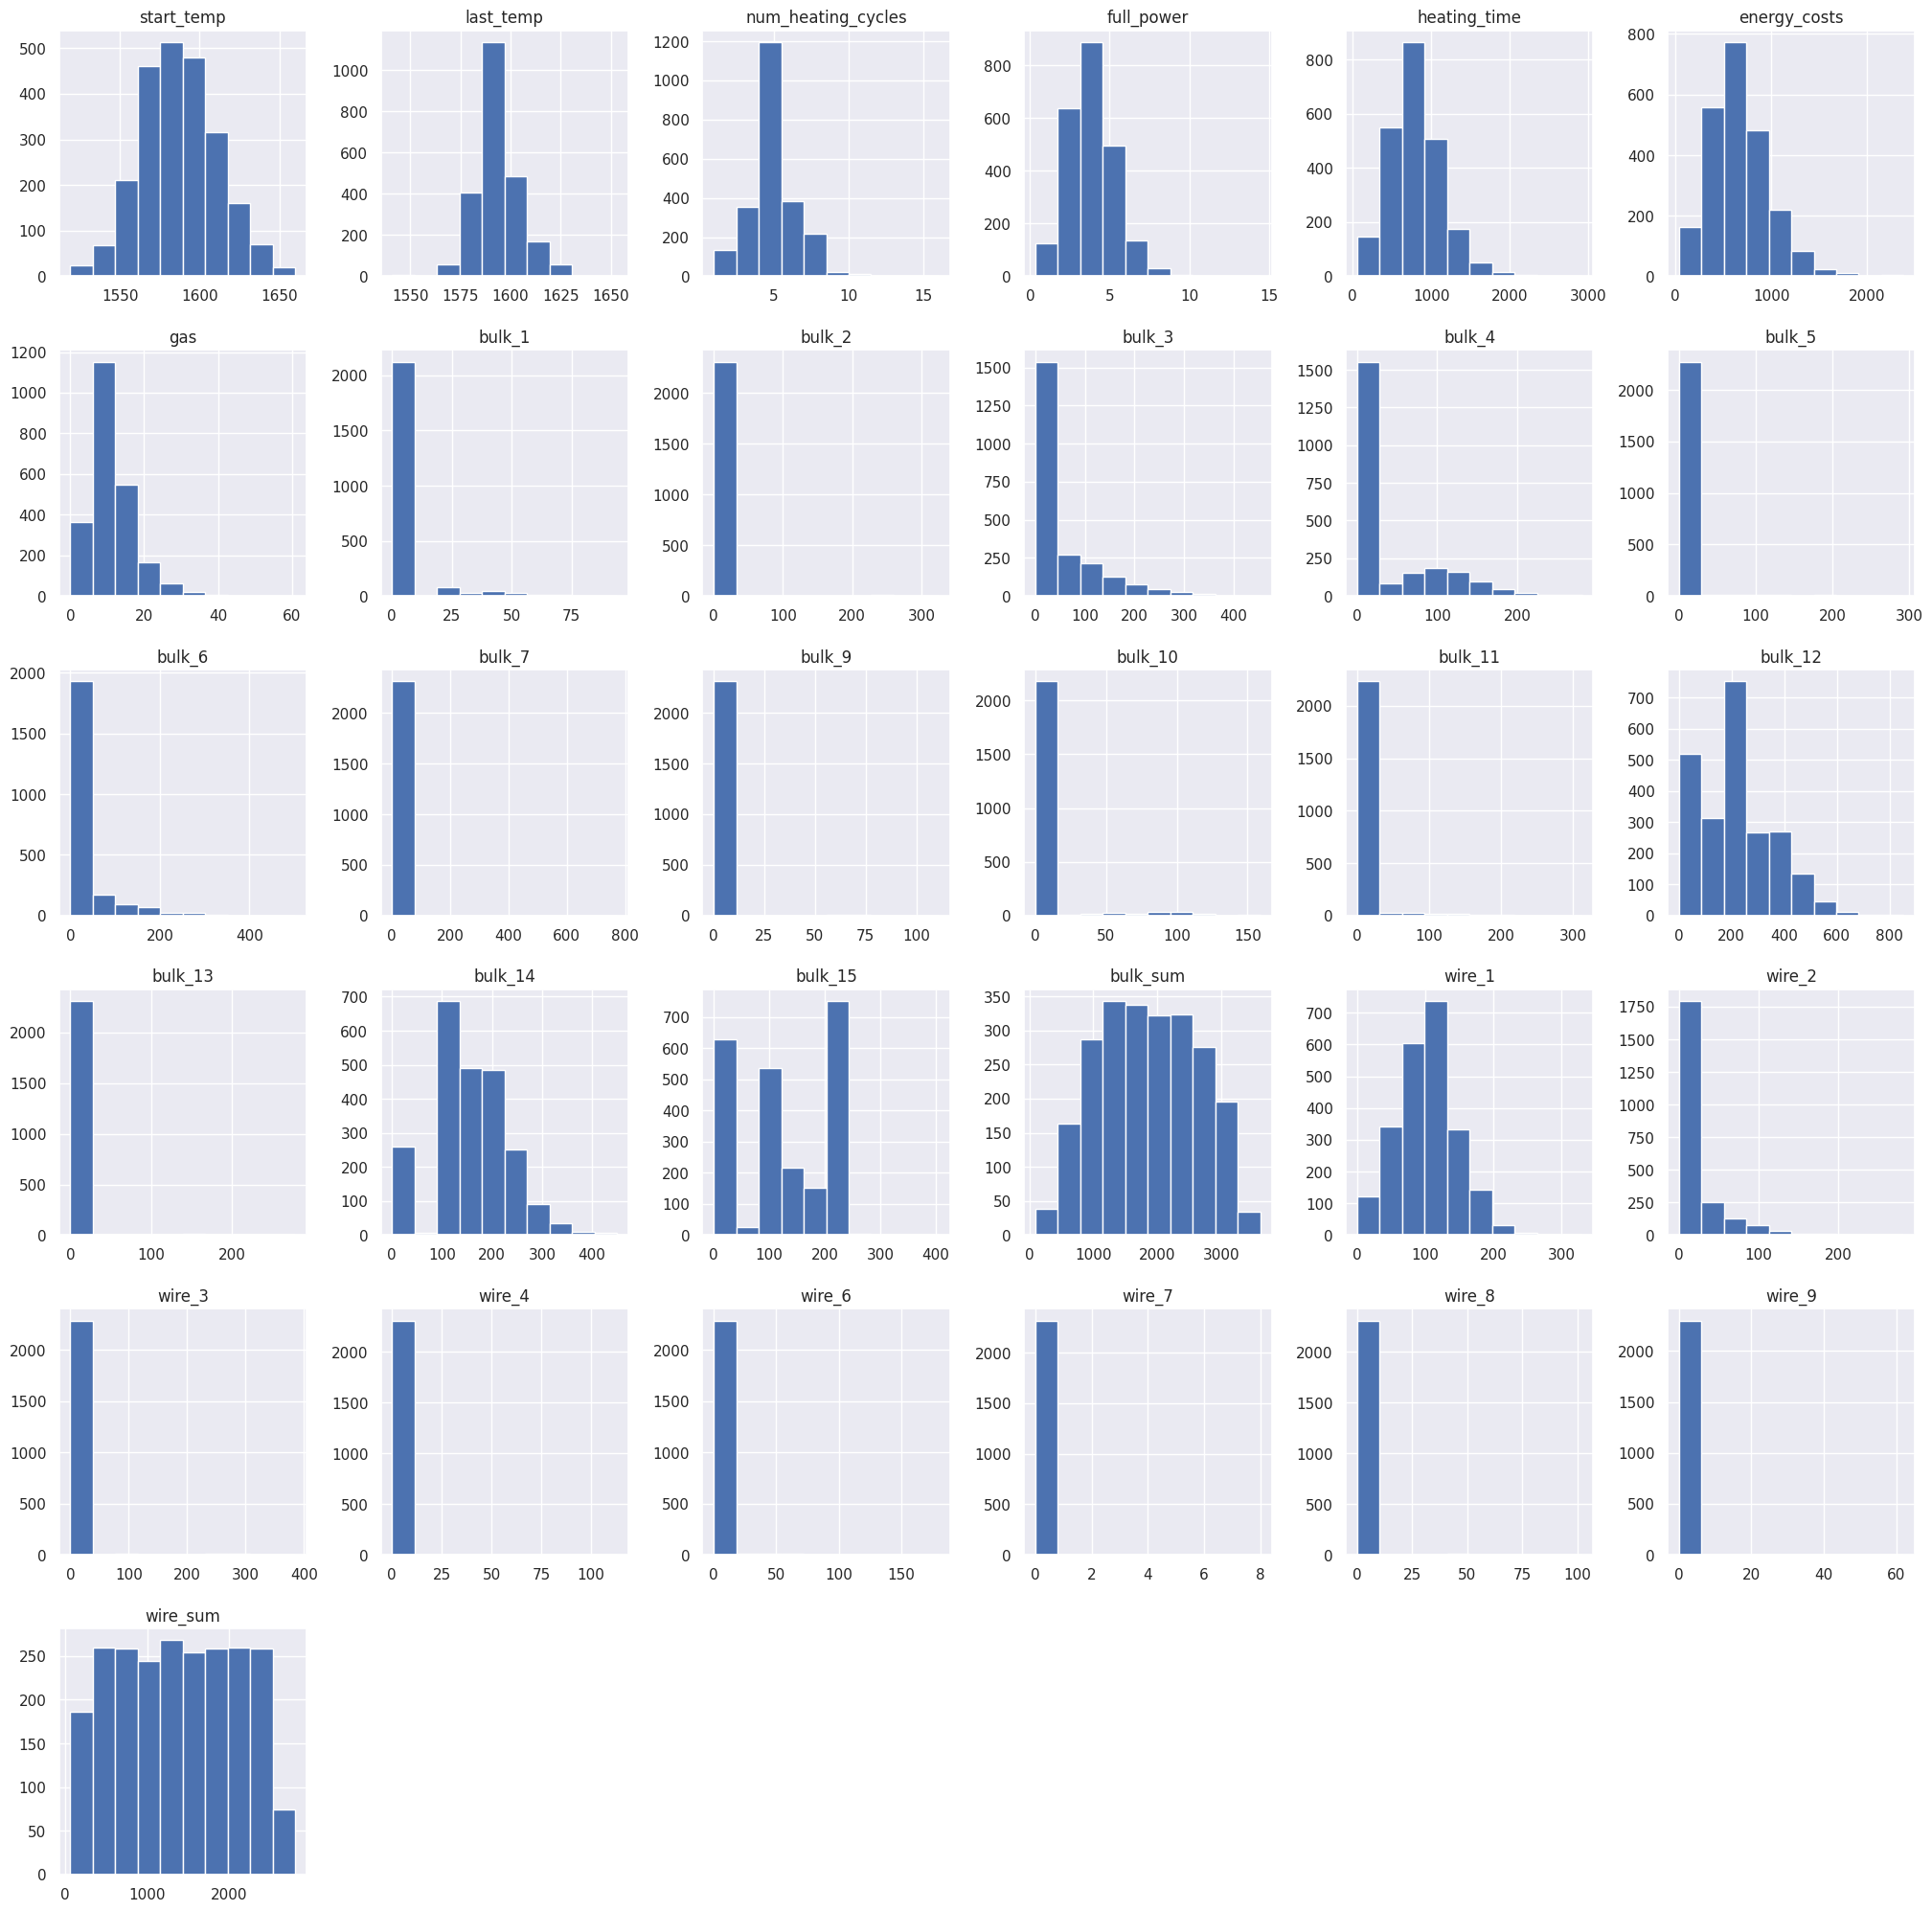

In [62]:
data.hist(figsize = (25,25));

Распределения, близкие к нормальным (или Пуассона):
start_temp,	min_temp, last_temp, num_heating_cycles, full_power, heating_time, energy_costs, gas, bulk_sum, wire_1
Остальные распределения не похожи на нормальное распределение, но в этом нет ничего странного, ведь оставшиеся распределения - это примеси, а примеси добавляются не рандомно, а по техпроцессу.

### Корреляционный анализ

interval columns not set, guessing: ['start_temp', 'last_temp', 'num_heating_cycles', 'full_power', 'heating_time', 'energy_costs', 'gas', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_sum', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_sum']


<Axes: >

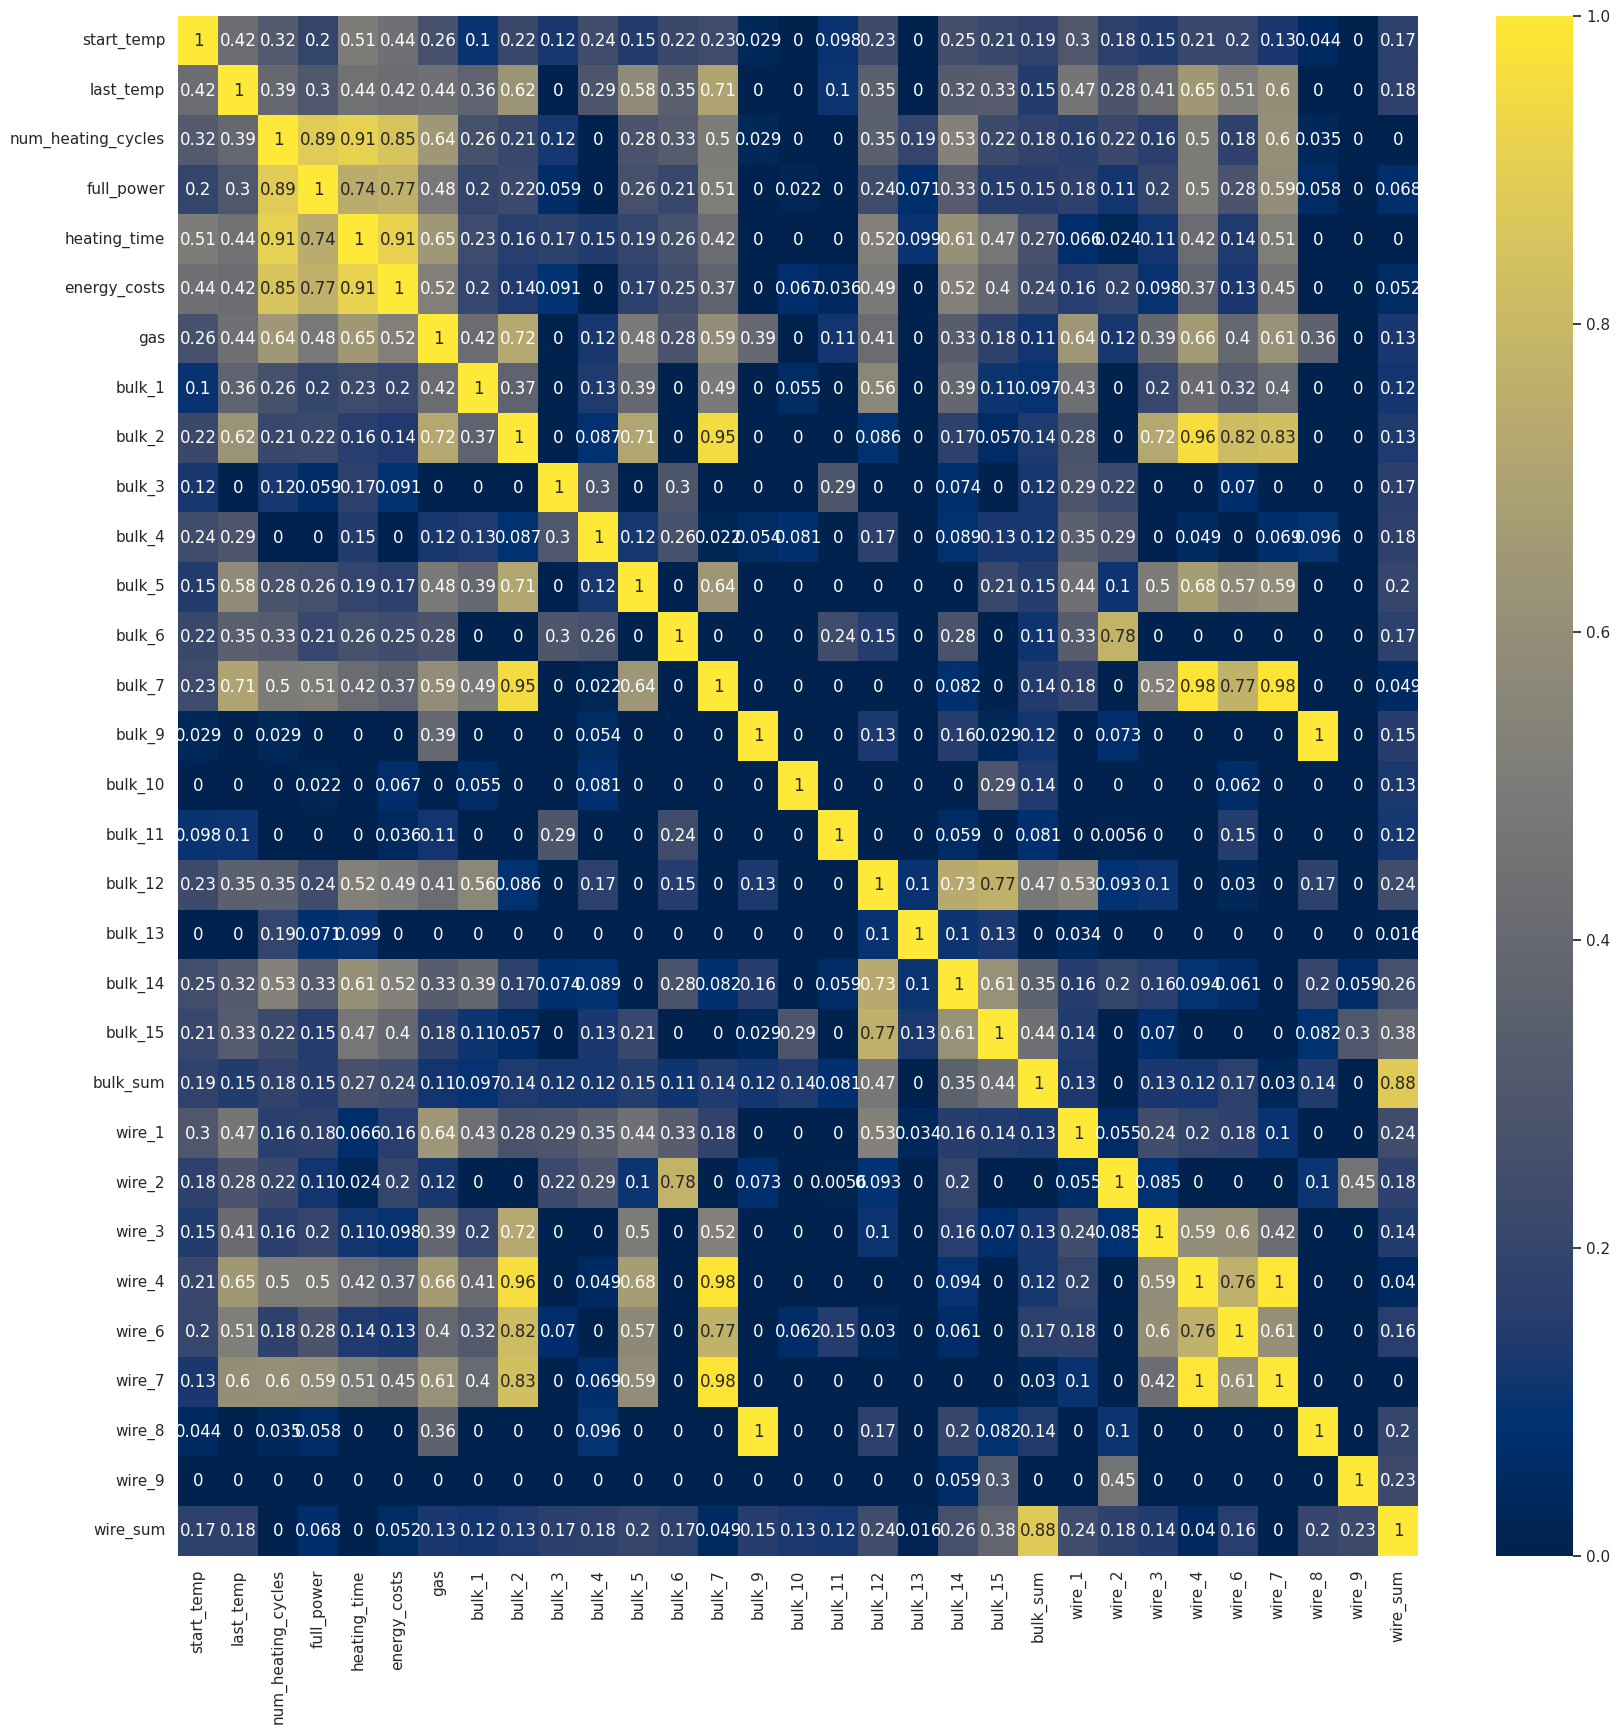

In [63]:
plt.figure(figsize = (20,20))
sns.heatmap(data.phik_matrix(), annot=True, cmap='cividis')

- Наблюдается высокая корреляция между суммарной мощностью, количеством циклов, временем нагрева и затратами энергии.
- Также наблюдается высокая корреляция между примесями bulk_2 и wire_4, wire_6, wire_7, bulk_7
- Также высокая корреляция между признаками минимальной и стартовой температуры
- Между примесями bulk_9 и wire_8 корреляция 1

Поскольку линейную регрессию использовать не планируется, признаки удалять не требуется.

In [64]:
# посмотрим корреляции с целевым признаком еще и списком
data.corr().round(3)['last_temp'].sort_values(ascending=False)

last_temp             1.000
wire_1                0.321
start_temp            0.301
heating_time          0.277
bulk_15               0.267
bulk_12               0.263
energy_costs          0.256
bulk_4                0.188
num_heating_cycles    0.176
full_power            0.170
bulk_14               0.109
bulk_10               0.062
gas                   0.050
wire_8               -0.002
bulk_9               -0.003
bulk_sum             -0.010
bulk_13              -0.024
wire_9               -0.028
bulk_3               -0.037
bulk_5               -0.039
wire_3               -0.047
bulk_2               -0.083
wire_6               -0.084
wire_sum             -0.090
bulk_1               -0.092
bulk_11              -0.115
bulk_7               -0.124
wire_7               -0.136
wire_4               -0.160
bulk_6               -0.185
wire_2               -0.212
Name: last_temp, dtype: float64

## Подготовка данных

In [65]:
X = data.drop('last_temp', axis=1)
y = data['last_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)

(1740, 30) (1740,)


Подготовлена разбивка на тренировочную и тестовую выборки в пропорции 0.75:0.25. В тренировочной выборке 1740 строк, что соотвествует условию >1700 строк

In [66]:
display(X_train.head())

start_temp  num_heating_cycles  full_power  heating_time  energy_costs  \
key                                                                            
1436        1612                   4    3.783957           819    818.028928   
416         1569                   6    5.258334          1797   1694.366829   
1684        1613                   5    4.326617           833    841.644330   
1488        1585                   4    2.555501           784    483.055176   
438         1589                   8    6.369420          1341   1113.438971   

            gas  bulk_1  bulk_2  bulk_3  bulk_4  ...  bulk_sum  wire_1  \
key                                              ...                     
1436   6.939387       0       0       0       0  ...      2116      88   
416   20.511666       0       0       0       0  ...      1228     112   
1684   9.935024       0       0      74       0  ...      1907     170   
1488  11.072334       0       0       0     133  ...      2033     108   
438   17.448153       0       0       0     176  ...      1439     171   

      wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  wire_sum  
key                                                                     
1436       0       0       0       0       0       0       0      1524  
416       21       0       0       0       0       0       0       549  
1684      48       0       0       0       0       0       0      1902  
1488       0       0       0       0       0       0       0      1596  
438       18       0       0       0       0       0       0       627  

[5 rows x 30 columns]

В масштабировании нет необходимости, поскольку линейные модели не планируются к использованию

In [67]:
# Создаем результирующую таблицу
result_table = pd.DataFrame(columns=['model', 'MAE', 'train_time', 'predict_time'])
#result_table

## Обучение моделей машинного обучения

### RandomForestRegressor

In [68]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 3, 4],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
rf_model = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
rf_model.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [20, 25, 30],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 50, 100],
                         'random_state': [200524]},
             scoring='neg_mean_absolute_error')

In [69]:
rf_mae = round(abs(rf_model.best_score_), 2)
print('MAE RandomForestRegressor = ', rf_mae)

print(rf_model.best_params_)

MAE RandomForestRegressor =  6.36
{'bootstrap': True, 'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 200524}


In [70]:
%%time
start = time.time()
rf_best_model = rf_model.best_estimator_
rf_best_model.fit(X_train, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели RandomForestRegressor: {train_time} мин')

start = time.time()
rf_best_model.predict(X_train)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели RandomForestRegressor: {predict_time} мин')

Время обучения модели RandomForestRegressor: 0.04880725145339966 мин
Время предсказания модели RandomForestRegressor: 0.0008338689804077148 мин
CPU times: user 2.91 s, sys: 7.96 ms, total: 2.92 s
Wall time: 2.98 s


In [71]:
result_table_1 = pd.DataFrame(
            {
                'model': 'RandomForestRegressor', 'MAE': rf_mae,
                'train_time': train_time, 'predict_time': predict_time
        }, index=[0])
#result_table_1

In [72]:
result_table = pd.concat([result_table, result_table_1], ignore_index = True)
result_table

model   MAE  train_time  predict_time
0  RandomForestRegressor  6.36    0.048807      0.000834

### CatBoostRegressor

In [73]:
model = CatBoostRegressor()
parameters = {
    'learning_rate':[0.06, 0.065, 0.07, 0.075, 0.08],
    'random_state':[RANDOM_STATE],
    'verbose':[False]
}
cat_model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
cat_model.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7b0df2f14dc0>,
             param_grid={'learning_rate': [0.06, 0.065, 0.07, 0.075, 0.08],
                         'random_state': [200524], 'verbose': [False]},
             scoring='neg_mean_absolute_error')

In [74]:
cat_mae = round(abs(cat_model.best_score_), 2)
print('MAE CatBoostRegressor = ', cat_mae)

print(cat_model.best_params_)

MAE CatBoostRegressor =  6.35
{'learning_rate': 0.065, 'random_state': 200524, 'verbose': False}


In [75]:
%%time
start = time.time()
cat_best_model = cat_model.best_estimator_
cat_best_model.fit(X_train, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели CatBoostRegressor: {train_time} мин')

start = time.time()
cat_best_model.predict(X_train)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели CatBoostRegressor: {predict_time} мин')

Время обучения модели CatBoostRegressor: 0.09094818035761515 мин
Время предсказания модели CatBoostRegressor: 8.23060671488444e-05 мин
CPU times: user 8 s, sys: 515 ms, total: 8.52 s
Wall time: 5.46 s


In [76]:
result_table_2 = pd.DataFrame(
            {
                'model': 'CatBoostRegressor', 'MAE': cat_mae,
                'train_time': train_time, 'predict_time': predict_time
        }, index=[1])
result_table = pd.concat([result_table, result_table_2], ignore_index = True)
result_table

model   MAE  train_time  predict_time
0  RandomForestRegressor  6.36    0.048807      0.000834
1      CatBoostRegressor  6.35    0.090948      0.000082

### Light Gradient Boosted Machine (LightGBM)

In [77]:
model = LGBMRegressor()
parameters = {
    'learning_rate':[0.03, 0.04, 0.05, 0.06, 0.07],
    'max_depth': [15, 16, 17],
    'random_state':[RANDOM_STATE],

}
lgbm_model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2638
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 21
[LightGBM] [Info] Start training from score 1593.469828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 22
[LightGBM] [Info] Start training from score 1593.140086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You c

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
                         'max_depth': [15, 16, 17], 'random_state': [200524]},
             scoring='neg_mean_absolute_error')

In [78]:
lgbm_mae = round(abs(lgbm_model.best_score_), 2)
print('MAE LGBMRegressor = ', lgbm_mae)

print(lgbm_model.best_params_)

MAE LGBMRegressor =  6.34
{'learning_rate': 0.04, 'max_depth': 16, 'random_state': 200524}


In [79]:
%%time
start = time.time()
lgbm_best_model = lgbm_model.best_estimator_
lgbm_best_model.fit(X_train, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели LGBMRegressor: {train_time} мин')

start = time.time()
lgbm_best_model.predict(X_train)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели LGBMRegressor: {predict_time} мин')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2843
[LightGBM] [Info] Number of data points in the train set: 1740, number of used features: 22
[LightGBM] [Info] Start training from score 1593.368966
Время обучения модели LGBMRegressor: 0.0030518293380737303 мин
Время предсказания модели LGBMRegressor: 0.0003827810287475586 мин
CPU times: user 204 ms, sys: 5.03 ms, total: 209 ms
Wall time: 206 ms


In [80]:
result_table_3 = pd.DataFrame(
            {
                'model': 'LGBMRegressor', 'MAE': lgbm_mae,
                'train_time': train_time, 'predict_time': predict_time
        }, index=[2])
result_table = pd.concat([result_table, result_table_3], ignore_index = True)
result_table

model   MAE  train_time  predict_time
0  RandomForestRegressor  6.36    0.048807      0.000834
1      CatBoostRegressor  6.35    0.090948      0.000082
2          LGBMRegressor  6.34    0.003052      0.000383

## Выбор лучшей модели

### Проверка моделей на адекватность

In [81]:
# DummyRegressor модель
dummy_mean = DummyRegressor()
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_test)
mae_score = mean_absolute_error(y_test, dummy_prediction)

mae_score = round(abs(mae_score), 2)
print('MAE DummyRegressor = ', mae_score)

MAE DummyRegressor =  8.06


In [82]:
print('MAE DummyRegressor больше, чем MAE RandomForestRegressor в ', round(mae_score/rf_mae,2), 'раз')
print('MAE DummyRegressor больше, чем MAE CatBoostRegressor в ', round(mae_score/cat_mae,2), 'раз')
print('MAE DummyRegressor больше, чем MAE LGBMRegressor в ', round(mae_score/lgbm_mae,2), 'раз')

MAE DummyRegressor больше, чем MAE RandomForestRegressor в  1.27 раз
MAE DummyRegressor больше, чем MAE CatBoostRegressor в  1.27 раз
MAE DummyRegressor больше, чем MAE LGBMRegressor в  1.27 раз


MAE константной модели равняется 8,06, что значительно выше, чем MAE обученных моделей.
- MAE DummyRegressor больше, чем MAE RandomForestRegressor в  1.27 раз
- MAE DummyRegressor больше, чем MAE CatBoostRegressor в  1.27 раз
- MAE DummyRegressor больше, чем MAE LGBMRegressor в  1.27 раз

Таким образом, можно сделать вывод, что все три обученные модели адекватны и далее следует выбрать лучшую из них.

### MAE и R2 лучшей модели

По результатам обучения лучшая модель - LGBMRegressor с параметрами {'learning_rate': 0.04, 'max_depth': 16, 'random_state': 200524} Ее MAE на тренировочной выборке минимально из трех проверенных моделей и равно 6.34.

Проверка модели на тестовой выборке:

In [83]:
model = lgbm_best_model
#model = cat_best_model
#model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('MAE LGBMRegressor на тестовой выборке = ', mae)

MAE LGBMRegressor на тестовой выборке =  5.92


Расчет метрики R2 на тестовой выборке:

In [84]:
r2 = r2_score(y_test, y_pred)
print("R^2 LGBMRegressor на тестовой выборке = ", round(r2, 2))

R^2 LGBMRegressor на тестовой выборке =  0.48


- Средняя абсолютная ошибка (MAE) на тестовой выборке составляет 5.92 С, и это неплохой результат предсказания, учитывая, что мы оперируем температурами от 1500С.
- Коэффициент детерминации (R^2) на тестовой выборке равен 0,48 - близкий к 0,5 , что означает, что модель имеет среднюю предсказывающую способность. Модель может быть использована для прогнозирования будущих значений зависимой переменной со средней степенью точности, поэтому в дальнейшем желательно собрать больше данных, чтобы доработать модель.

### Важность признаков лучшей модели

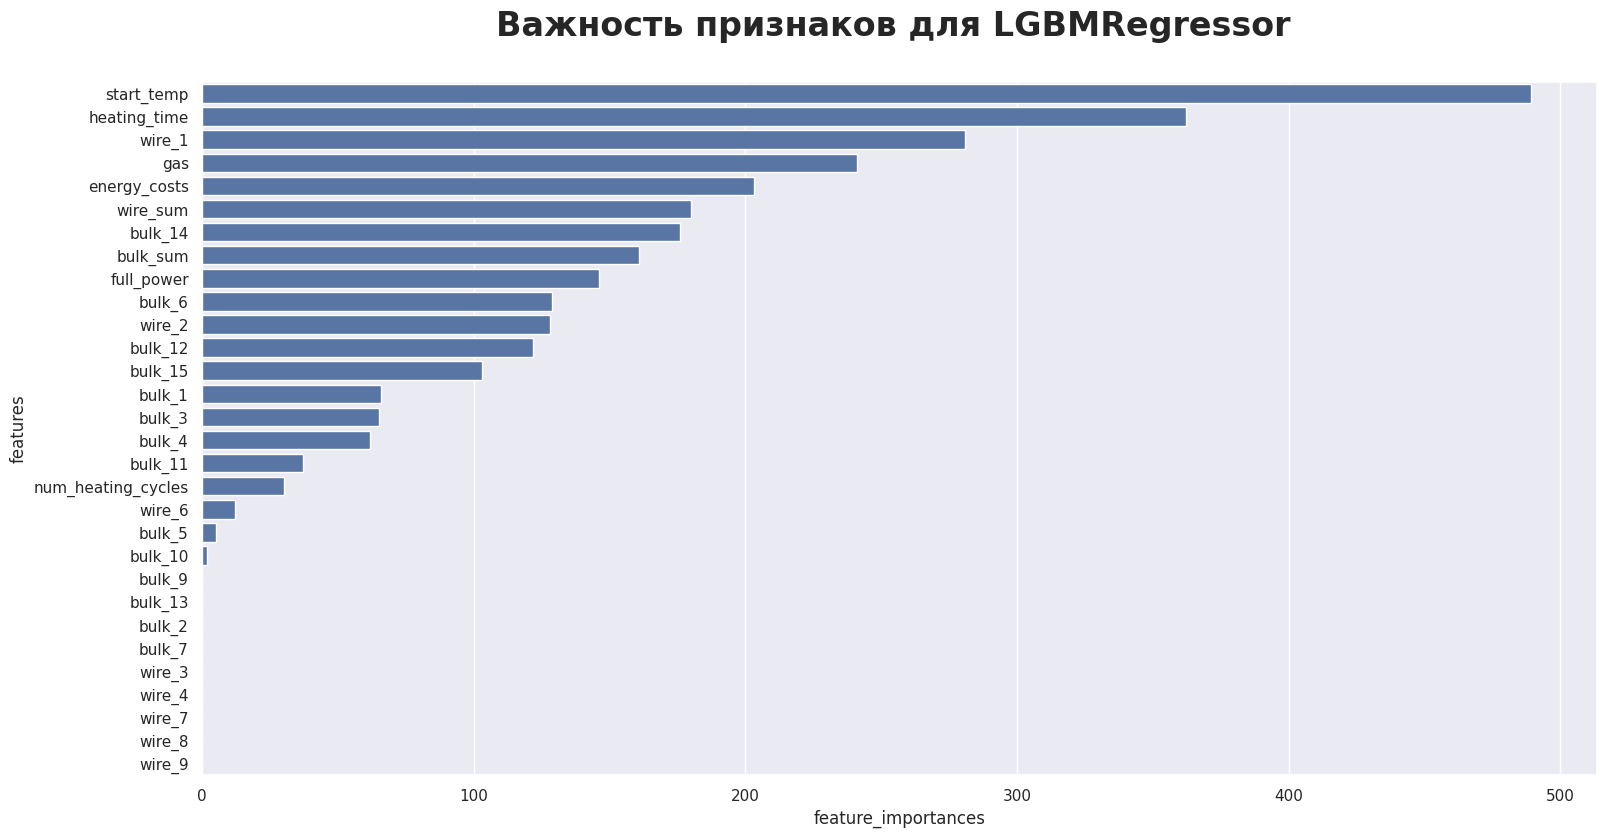

In [85]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': lgbm_best_model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для LGBMRegressor \n', fontsize=24, fontweight="bold")
plt.show()

In [86]:
plot_data['percent']=round(plot_data['feature_importances']/(sum(plot_data['feature_importances']))*100, 2)
plot_data.head(15)

features  feature_importances  percent
0     start_temp                  489    16.30
3   heating_time                  362    12.07
21        wire_1                  281     9.37
5            gas                  241     8.03
4   energy_costs                  203     6.77
29      wire_sum                  180     6.00
18       bulk_14                  176     5.87
20      bulk_sum                  161     5.37
2     full_power                  146     4.87
11        bulk_6                  129     4.30
22        wire_2                  128     4.27
16       bulk_12                  122     4.07
19       bulk_15                  103     3.43
6         bulk_1                   66     2.20
8         bulk_3                   65     2.17

Наиболее важными признаками для модели LGBMRegressor, выбранной в качестве лучшей модели для рекомендации заказчику, являются (важность указана в процентах через дефис):
- start_temp (начальная температура) - 16,3%
- heating_time	(время нагрева) - 12,07%
- wire_1	(проволочная добавка 1) - 9,37%
- gas	(газ) - 8,03%
- energy_costs	(расход энергии) - 6,77%
- wire_sum	(общее количество проволочных добавок) - 6%
- bulk_14	(сыпучая добавка 14) - 5,87%
- bulk_sum	(общее количество сыпучих добавок) - 5,37%
- full_power	(полная мощность) - 4,87%
- bulk_6	(сыпучая добавка  6) - 4,3%
- wire_2	(проволочная добавка 1)- 4,27%
- bulk_12	(сыпучая добавка  12) - 4,07%
- bulk_15	(сыпучая добавка  15) - 3,43%
- bulk_1	(сыпучая добавка 1) - 2,2%
- bulk_3	(сыпучая добавка  3) - 2,17%

### Важность по Шепли

In [87]:
!pip install shap -q
import shap

In [88]:
model = lgbm_best_model

In [89]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

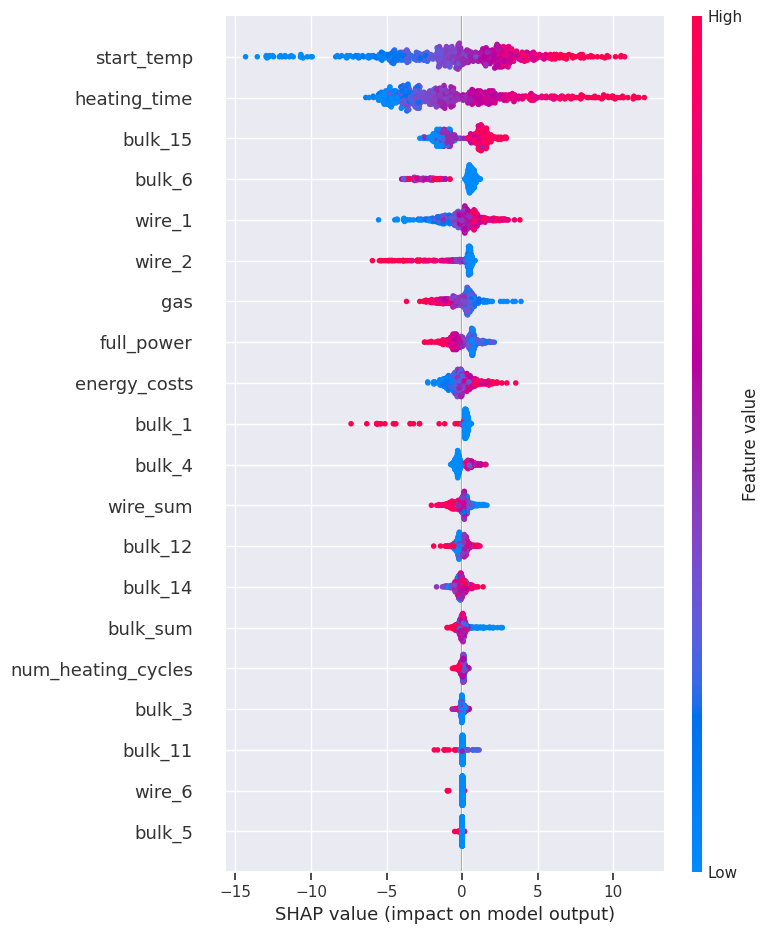

In [90]:
shap.summary_plot(shap_values, X_test)

- Чем выше начальная температура и время нагрева, тем выше будет и конечная температура.
- Чем больше добавили сыпучей примеси bulk_15 и проволочной добавки wire_1, тем выше конечная температура.
- Чем больше добавили сыпучей примеси bulk_6 и проволочной добавки wire_2, тем ниже конечная температура.
- Также признаки, влияющие на уменьшение конечной температуры сплава: сыпучая примесь bulk_1, объем газа и общая мощность
- Также увеличивает конечную температуру количество энергии
- Остальные признаки менее значимы

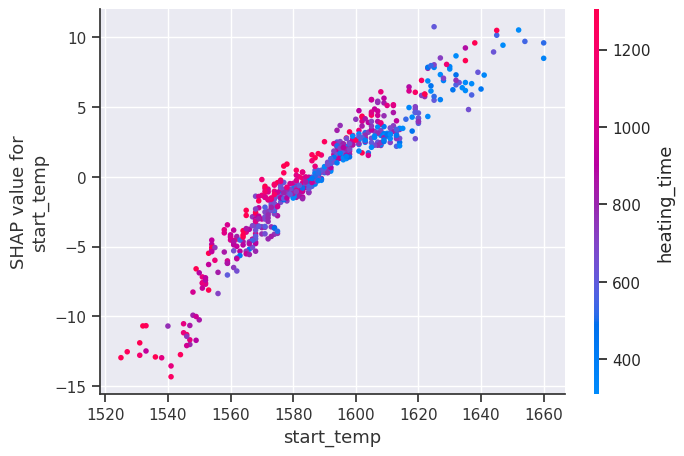

In [91]:
shap.dependence_plot("start_temp", shap_values, X_test)

Изучим совместное распределение SHAPE-значений для пары признаков start_temp и heating_time/
По распределению видно, что стартовые температуры выше 1590 С повышают итоговую температуру сплава, а врем янагрева тем больше повышает ее, чем оно короче

## Общий вывод и рекомендации заказчику

### Описание данных
`data_arc_new.csv` — данные об электродах:\
В датасете 5 колонок: ключ (номер партии), Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность\
Всего строк: 14876, нулей нет. Явных дубликатов нет. Уникальных ключей (партий) 3214. Одному ключу может соотвествовать несколько строк, это нормально, поскольку нагрев производится несколько раз в течение процесса.\
`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём):\
В датасете 16 колонок: ключ (номер партии) и 15 колонок сыпучих примесей, обозначенные Bulk1 - Bulk15. Всего 3129 строк, Уникальных ключей (партий) 3129. В колонке ключ нулевых значений нет (и они все уникальные), в колонках примесей есть пропуски, но это нормально, поскольку не все примеси добавляются в каждую партию. Следует заменить значением 0. Явных дубликатов нет.\
`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время):\
Одна примесь из всех была использована лишь раз.\
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом\
Уникальных ключей (партий) 3129 равно числу строк. В колонке ключ нулевых значений нет (и они все уникальные). Явных дубликатов нет.\
`data_gas_new.csv` — данные о продувке сплава газом:\
2 колонки, ключ и Газ1, видимо, объем газа. Строк 3239, что на 110 строк больше, чем в датафреймах с сыпучими добавками. Пропусков нет. Уникальных ключей (партий) 3239 равно числу строк. Явных дубликатов нет. \
`data_temp_new.csv` — результаты измерения температуры:\
3 колонки: ключ, время замера и температура. 18092 строк, есть пропуски в колонке "температура", при этом в колонке "время замера" пропусков нет. Ключи с пропуском в замерах требуется удалить. Явных дубликатов нет. Уникальных ключей (партий) 3216. Одному ключу может соотвествовать несколько строк, это нормально, поскольку замер температуры производится несколько раз в течение процесса.\
Минимум температуры меньше 1500С\
`data_wire_new.csv` — данные о проволочных материалах (объём):\
10 колонок: ключ и колонки Wire 1 - Wire 9, отвечающие за проволочные присадки. 3081 строка, в колонках проволочных присадок есть пропуски, их можно заменить нулями. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет. \
Одна примесь из всех была использована лишь раз.\
`data_wire_time_new.csv` — данные о проволочных материалах (время):
Здесь по пропускам картина полностью повторяет датасет с примесями, отличается только тип данных obj.  Эта таблица поможет нам проконтролировать ошибки в данных, поскольку добавки не должны поступать с большим перерывом. Уникальных ключей (партий) 3081 равно числу строк. Явных дубликатов нет.\


### Исследовательский анализ датасетов
`data_arc_new.csv` — данные об электродах;
- Обнаружена аномалия в области отрицательных значений мощности. Восстановить верные данные не представляется возможным, ключ удален.
- После удаления наблюдаем распределение мощностей, похожее на распределение Пуассона со сдвигом влево. Аномалий нет.
- Рассчитано общее время нагрева по каждому циклу, полная мощность а также затраты электроэнергии
- Произведено удаление неактуальных столбцов: время начала нагрева, время конца нагрева, активная мощность, реактивная мощность
- Произведена агрегация столбцов по ключу с расчетом количества циклов нагрева.
- После агрегации удалена появившаяся аномалия в высоких значениях (4189) в столбце `heating_time`

`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- Обнаружена и удалена явная аномалия в значении 603 для сыпучей примеси bulk_5.
- Обнаружена и удалена явная аномалия в значении 1849 для сыпучей примеси bulk_12.
- Обнаружено, что примесь bulk_8 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. Удален этот ключ и затем удален столбец bulk_8. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, удален и ключ тоже
- Добавлен дополнительный столбец с суммарным количеством примесей `bulk_sum`
- Пропуски заполнены значениями 0

`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 2,5 часов)

`data_gas_new.csv` — данные о продувке сплава газом:
- Обнаружены редко встречающиеся значения ~61 и ~78, выглядящие как аномалии, однако, вполне возможно, такое большое количество газа потребовалось для партий, где было больше всего циклов нагрева. Значения не удалены из предположения. что это редкие значения.


`data_temp_new.csv` — результаты измерения температуры;
- Удалены пропуски в датасете температур,
- Удалены ключи с температурами ниже 1500С (по регламенту должно быть не ниже этого значения),
- Агрегированы данные - одна колонка температур преобразована в три колонки по ключам: начальная температура, минимальная, конечная температура. Промежуточные значения температур удалены.


`data_wire_new.csv` — данные о проволочных материалах (объём);
- Аномалий не обнаружено.
- Обнаружено, что примесь wire_5 использовалась только один раз. На основании одного использования невозможно рассчитать закономерности. **Важно** Ключ удален целиком, а не просто удален столбец, по той причине, что мы не знаем, как даже минимальное количество этой добавки может влиять на температуру, поэтому во избежание ошибки модели, сначала удалена строка, затем уже столбец.
- Добавлен дополнительный столбец с суммарным количеством добавок `wire_sum`
- Пропуски заполнены значениями 0


`data_wire_time_new.csv` — данные о проволочных материалах (время).
- Рассчитано суммарное время на добавление примесей
- Обнаружены и удалены три аномалии (время более 4000 с)

###  Объединение данных и анализ объединенного датасета

Датасеты `data_bulk_time_new` и `data_wire_time_new` в итоговую таблицу не вошли: они были нужны для проверки корректности данных. Объединены данные по ключу `key`, ключ в дальнейшем назначен индексом.

In [92]:
data.shape

(2321, 31)

In [93]:
data.tail()

start_temp  last_temp  num_heating_cycles  full_power  heating_time  \
key                                                                         
2495        1570       1591                   4    3.868721           723   
2496        1554       1591                   6    5.070316           940   
2497        1571       1589                   3    4.360918           569   
2498        1591       1594                   5    3.909917           750   
2499        1569       1603                   4    2.169252           883   

      energy_costs        gas  bulk_1  bulk_2  bulk_3  ...  bulk_sum  wire_1  \
key                                                    ...                     
2495    694.177326   7.125735       0       0      21  ...      3214      89   
2496    815.818538   9.412616       0       0       0  ...      3292     114   
2497    823.020520   6.271699       0       0       0  ...      3162      94   
2498    581.810739  14.953657       0       0      90  ...      3231     118   
2499    532.386183  11.336151       0       0      47  ...      3132     110   

      wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  wire_sum  
key                                                                     
2495       0       0       0       0       0       0       0      2584  
2496       0       0       0       0       0       0       0      2610  
2497       9       0       0       0       0       0       0      2600  
2498       0       0       0       0       0       0       0      2616  
2499      50       0       0       0       0       0       0      2659  

[5 rows x 31 columns]

Всего в итоговой таблице 2321 строка,32 колонки признаков, включая целевой.
Ключи со значением более 2499 в таблицу не вошли (для этих клюней имеется лишь один замер температуры, на основании чего невозможно построить модель)

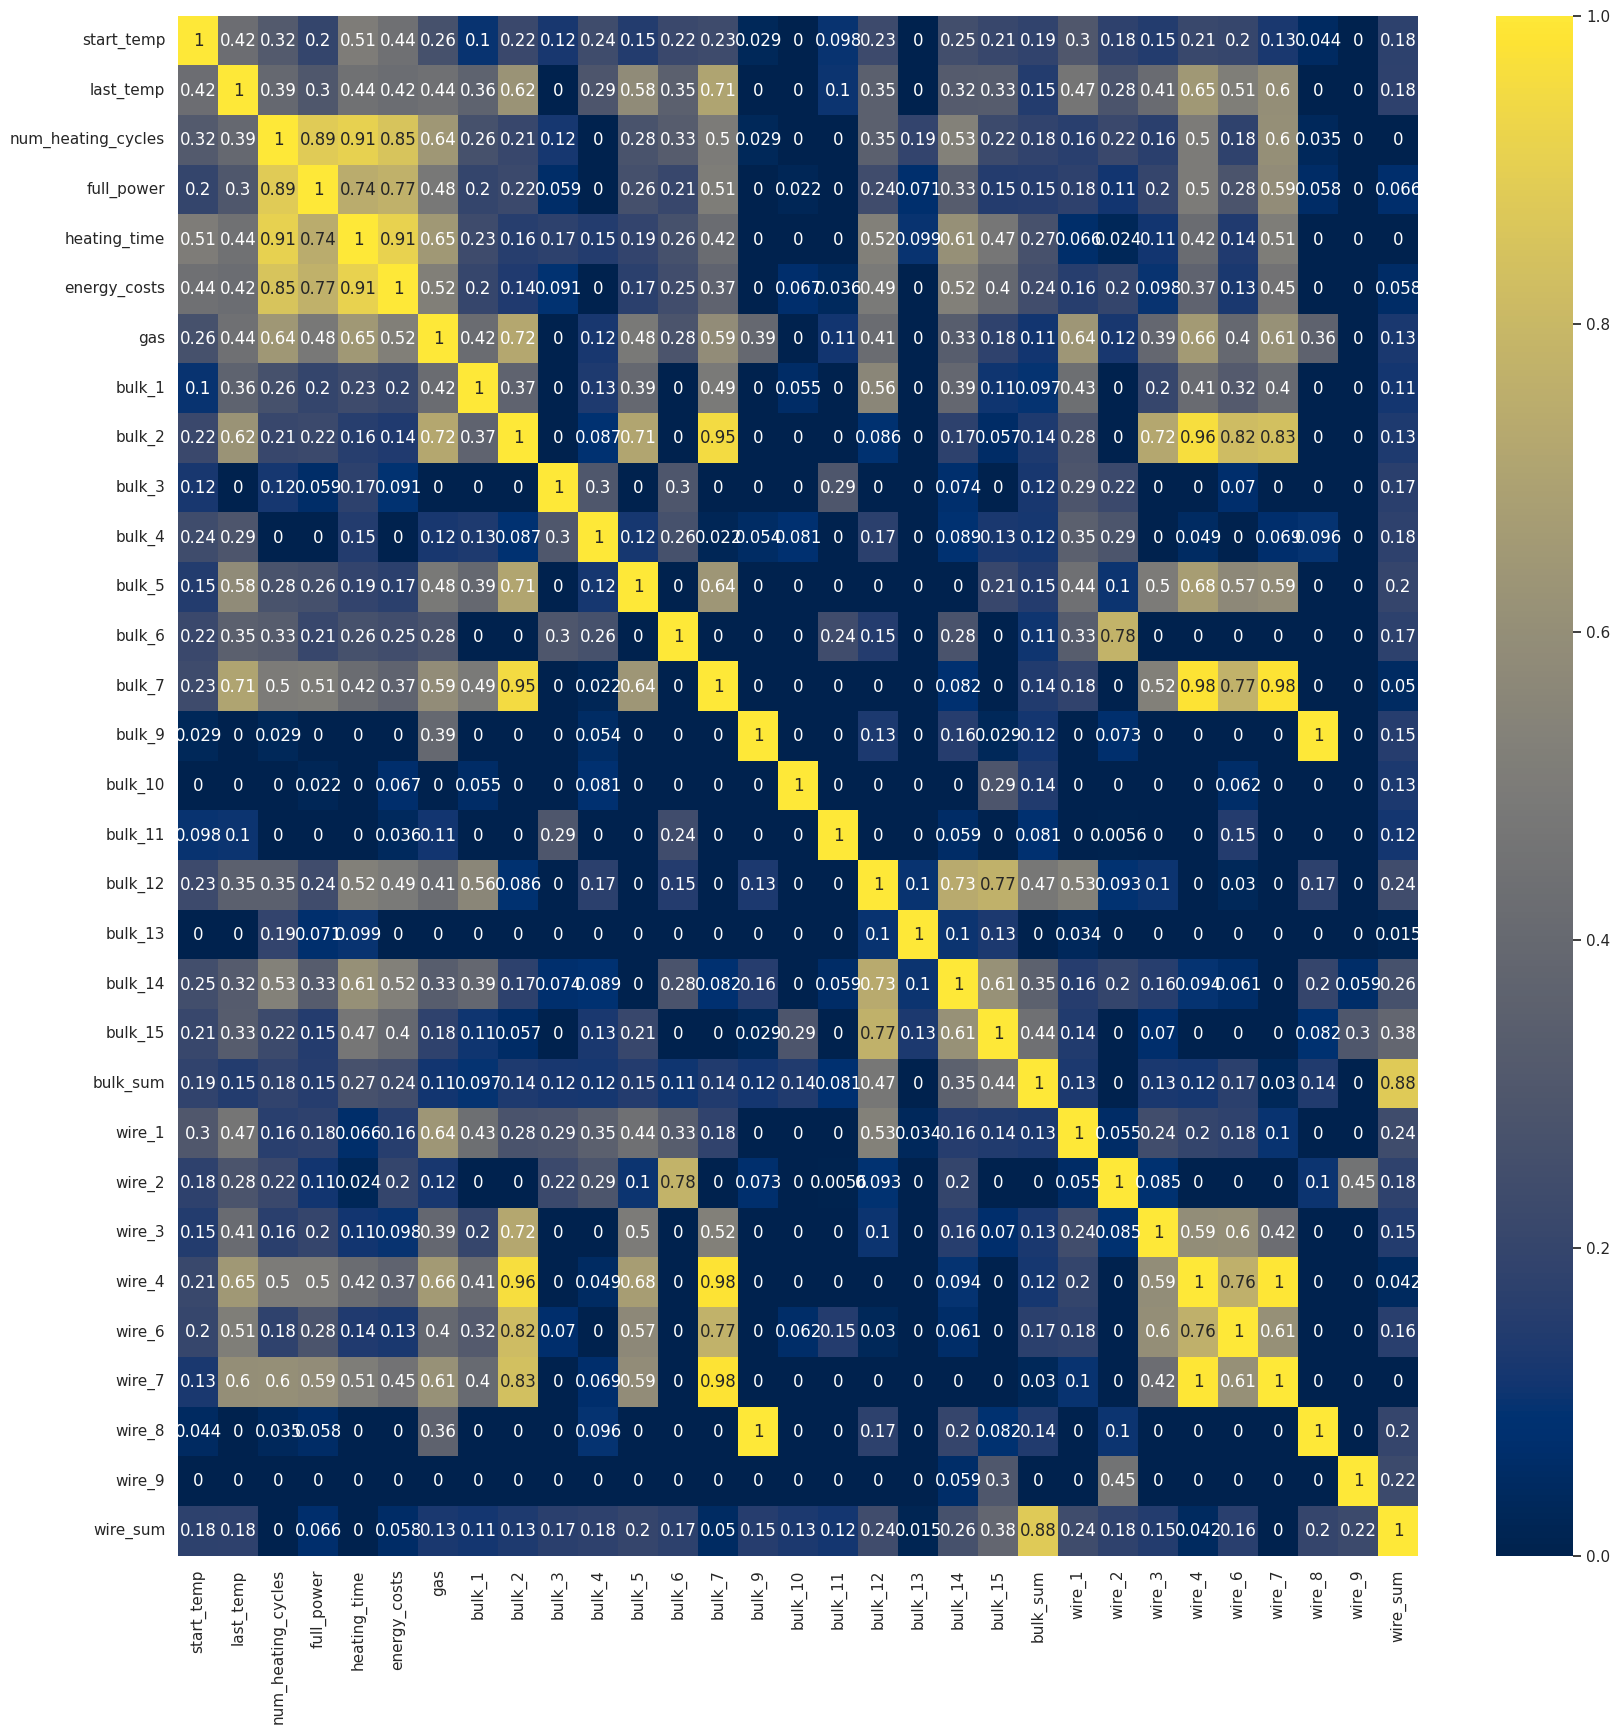
- Наблюдается высокая корреляция между суммарной мощностью, количеством циклов, временем нагрева и затратами энергии.
- Также наблюдается высокая корреляция между примесями bulk_2 и wire_4, wire_6, wire_7, bulk_7
- Также высокая корреляция между признаками минимальной и стартовой температуры
- Между примесями bulk_9 и wire_8 корреляция 1

Поскольку линейную регрессию использовать не планировалось, признаки не были удалены.

### Подготовка данных и обучение моделей машинного обучения.


In [94]:
print(X_train.shape, y_train.shape)

(1740, 30) (1740,)


Подготовили разбивку на тренировочную и тестовую выборки в пропорции 0.75:0.25. В тренировочной выборке 1740 строк, что соотвествует условию >1700 строк.
В масштабировании не было необходимости, поскольку линейные модели не планировались к использованию.
Константа RANDOM_STATE (включая разбивку на тренировочную и тестовую выборки,а также обучение моделей и кросс-валидацию):
- RANDOM_STATE = 200524

Обучили три модели машинного обучения:
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

Для каждой из моделей провели подбор параметров на кросс-валидации, вычислили метрику MAE на тестовой выборке и измерили время обучения.

In [95]:
result_table

model   MAE  train_time  predict_time
0  RandomForestRegressor  6.36    0.048807      0.000834
1      CatBoostRegressor  6.35    0.090948      0.000082
2          LGBMRegressor  6.34    0.003052      0.000383

### Выбор лучшей модели и ее описание

Произведена проверка на адекватность модели. Использована константная модель DummyRegressor

In [96]:
print('MAE DummyRegressor = ', mae_score)

MAE DummyRegressor =  8.06


MAE константной модели равняется 8,06, что значительно выше, чем MAE наших обученных моделей.

In [97]:
print('MAE DummyRegressor больше, чем MAE RandomForestRegressor в ', round(mae_score/rf_mae,2), 'раз')
print('MAE DummyRegressor больше, чем MAE CatBoostRegressor в ', round(mae_score/cat_mae,2), 'раз')
print('MAE DummyRegressor больше, чем MAE LGBMRegressor в ', round(mae_score/lgbm_mae,2), 'раз')

MAE DummyRegressor больше, чем MAE RandomForestRegressor в  1.27 раз
MAE DummyRegressor больше, чем MAE CatBoostRegressor в  1.27 раз
MAE DummyRegressor больше, чем MAE LGBMRegressor в  1.27 раз


По результатам обучения лучшая модель - LGBMRegressor с параметрами:
- {'learning_rate': 0.04, 'max_depth': 16, 'random_state': 200524}
Ее MAE на тренировочной выборке минимально из трех проверенных моделей и равно 6.34.

Модель проверена на тестовой выборке, также рассчитана метрика R^2

In [98]:
print('MAE LGBMRegressor на тестовой выборке = ', mae)
print("R^2 LGBMRegressor на тестовой выборке = ", round(r2, 2))

MAE LGBMRegressor на тестовой выборке =  5.92
R^2 LGBMRegressor на тестовой выборке =  0.48


- **Средняя абсолютная ошибка (MAE) на тестовой выборке составляет 5.89 С**, и это неплохой результат предсказания, учитывая, что мы оперируем температурами от 1500С.
- Коэффициент детерминации (R^2) на тестовой выборке равен 0,48 - близкий к 0,5 , что означает, что модель имеет среднюю предсказывающую способность. Модель может быть использована для прогнозирования будущих значений зависимой переменной со средней степенью точности, поэтому в дальнейшем желательно собрать больше данных, чтобы доработать модель.

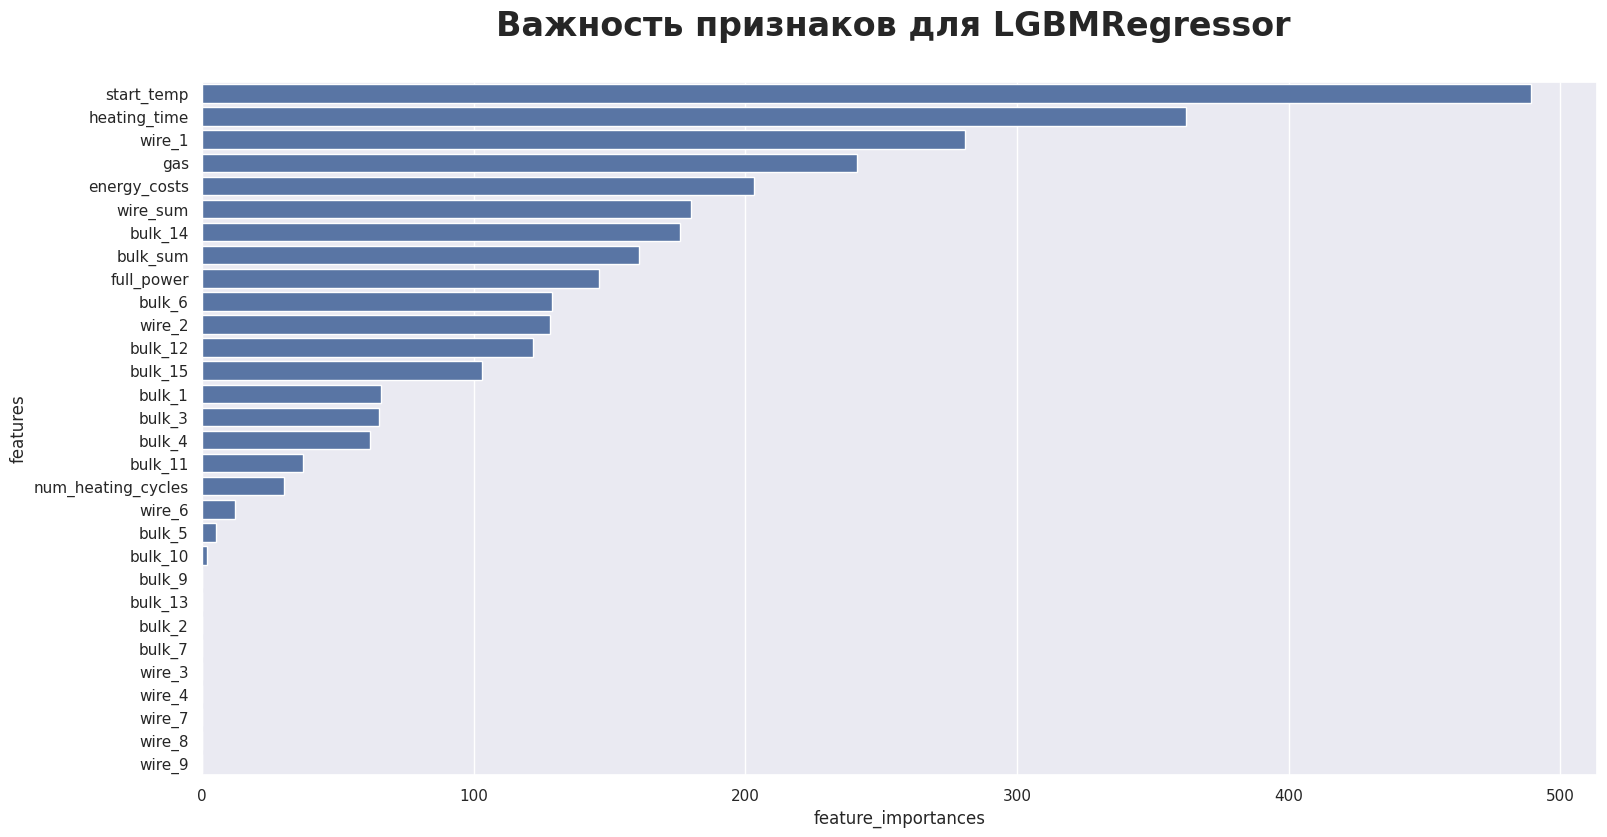

Наиболее важными признаками для модели CatboostRegressor, выбранной в качестве лучшей модели для рекомендации заказчику, являются (важность указана в процентах через дефис):
- start_temp (начальная температура) - 16,3%
- heating_time	(время нагрева) - 12,07%
- wire_1	(проволочная добавка 1) - 9,37%
- gas	(газ) - 8,03%
- energy_costs	(расход энергии) - 6,77%
- wire_sum	(общее количество проволочных добавок) - 6%
- bulk_14	(сыпучая добавка 14) - 5,87%
- bulk_sum	(общее количество сыпучих добавок) - 5,37%
- full_power	(полная мощность) - 4,87%
- bulk_6	(сыпучая добавка  6) - 4,3%
- wire_2	(проволочная добавка 1)- 4,27%
- bulk_12	(сыпучая добавка  12) - 4,07%
- bulk_15	(сыпучая добавка  15) - 3,43%
- bulk_1	(сыпучая добавка 1) - 2,2%
- bulk_3	(сыпучая добавка  3) - 2,17%

Среди основных значимых признаков в списке важное место занимают новые добавленные признаки.

График распределения признаков по Шепли

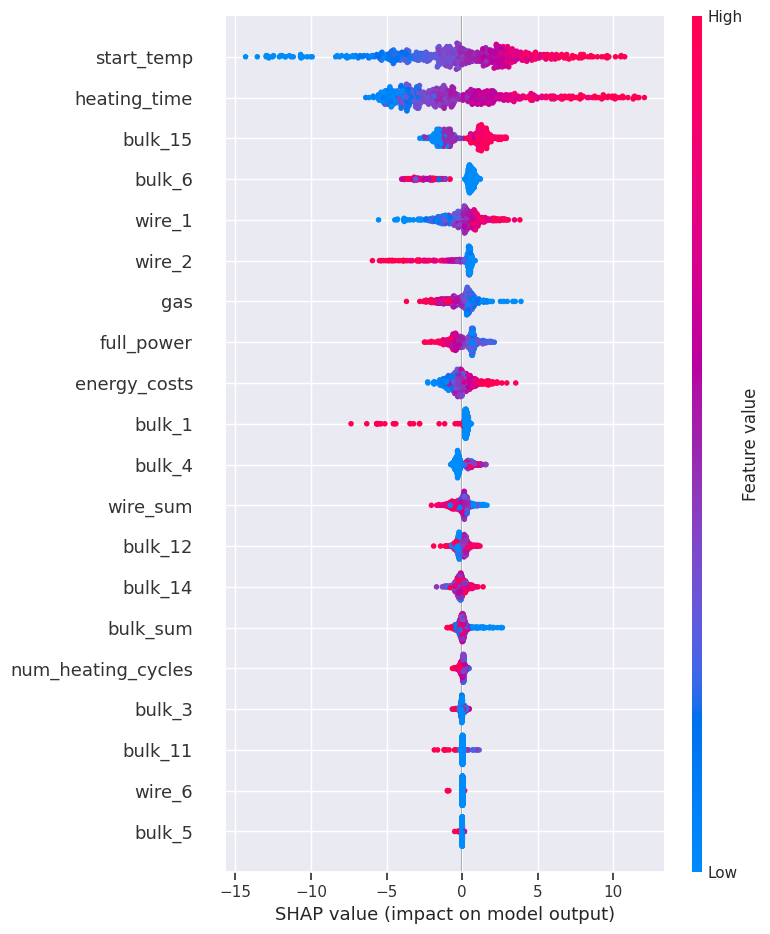

- Чем выше начальная температура и время нагрева, тем выше будет и конечная температура.
- Чем больше добавили сыпучей примеси bulk_15 и проволочной добавки wire_1, тем выше конечная температура.
- Чем больше добавили сыпучей примеси bulk_6 и проволочной добавки wire_2, тем ниже конечная температура.
- Также признаки, влияющие на уменьшение конечной температуры сплава: сыпучая примесь bulk_1, объем газа и общая мощность
- Также увеличивает конечную температуру количество энергии
- Остальные признаки менее значимы

### Рекомендации заказчику

- Для предсказания конечной температуры расплава рекомендована модель По результатам обучения лучшая модель - LGBMRegressor с параметрами {'learning_rate': 0.04, 'max_depth': 16, 'random_state': 200524} На тестовой выборке MAE = 5.89 и R^2 = 0,48.
- Для дальнейшего улучшения моделей можно рекомендовать отсеить признаки с низкой важностью, а также подумать в сторону поиска новых важных признаков.
- Кроме того, можно задать более широкий спектр гиперпараметров для автоматизированного подбора.
- Более всего на конечную температуру расплава влияет начальная температура процесса. Это очевидно, но необходимо это отметить.
- Также высокая степень влияния у признаков "время нагрева" и "расход энергии", это, казалось бы, тоже очевидно, но необходимо отметить этот момент.
- Следует обратить внимание на добавки(примеси), которые более всего влияют на конечную температуру расплава: wire_1, bulk_14, bulk_6, bulk_15, wire_2, а также на общее количество использованных проволочных добавок и сыпучих примесей, вклад этих факторов тоже заметен.
- Неудивительно, что определенное влияние на конечную температуру оказывает полная мощность и обьем газа, хотя это и очевидно, но следует это отметить.